トレーニング: 不動産価格予想

In [134]:
DIR_PATH = "/cpt_training"

In [135]:
cd {DIR_PATH}

[Errno 2] No such file or directory: '/cpt_training'
/Users/otoya/Documents/Develop/cpt_training


In [136]:
%pip install -U "setuptools<58" # setuptoolsのverが58以上だと、xfeatの依存パッケージml-metricsのinstallに失敗するため
%pip install -q optuna xfeat japanize-matplotlib
%pip install -q optuna


[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [137]:
# import
import re

import japanize_matplotlib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
sns.set(font="IPAexGothic")

from glob import glob
from functools import partial
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from xfeat import SelectCategorical, LabelEncoder, LambdaEncoder, Pipeline, ConcatCombination, SelectNumerical, \
    ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer
# パラメータチューニングで必要なライブラリ
import optuna
from sklearn.metrics import mean_absolute_error

In [138]:
pd.set_option('display.max_columns', None)

In [139]:
ID = 'ID'
TARGET = '取引価格（総額）_log'
time_col = '取引時点_enc'
group_col = '都道府県名'

In [140]:
BASE_PATH = './'

In [141]:
paths = glob(BASE_PATH + 'input/train/*.csv')
train_dfs = []
for path in paths:
    train_df = pd.read_csv(path)
    train_dfs.append(train_df)
train_df = pd.concat(train_dfs)
train_df.reset_index(drop=True, inplace=True)
test_df = pd.read_csv(BASE_PATH + 'input/test.csv')

# train_df, test_df, val_dfをくっつける
master_df = pd.concat([train_df, test_df])
master_df.sort_values('取引時点', inplace=True)
master_df.reset_index(drop=True, inplace=True)

/var/folders/sq/rqkt9m8947d5f6h6fxf4t9q00000gn/T/ipykernel_45276/2232468179.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(path)
/var/folders/sq/rqkt9m8947d5f6h6fxf4t9q00000gn/T/ipykernel_45276/2232468179.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(path)


In [142]:
master_df.columns

Index(['ID', '種類', '地域', '市区町村コード', '都道府県名', '市区町村名', '地区名', '最寄駅：名称',
       '最寄駅：距離（分）', '間取り', '面積（㎡）', '土地の形状', '間口', '延床面積（㎡）', '建築年', '建物の構造',
       '用途', '今後の利用目的', '前面道路：方位', '前面道路：種類', '前面道路：幅員（ｍ）', '都市計画', '建ぺい率（％）',
       '容積率（％）', '取引時点', '改装', '取引の事情等', '取引価格（総額）_log'],
      dtype='object')

In [143]:
set(test_df['取引時点'])

{'2020年第１四半期', '2020年第２四半期'}

In [144]:
sub_df = pd.read_csv(BASE_PATH + 'input/sample_submission.csv')

In [145]:
master_df.shape

(656817, 28)

In [146]:
class Preprocessor:
    TARGET = TARGET
    group_col = group_col
    time_col = time_col

    def __init__(self, df):
        self.df = df.copy()
        self.agg_dfs = []
        self.labeling()

    @staticmethod
    def normalize_moyori(moyori):
        if moyori == moyori:
            if moyori == '30分?60分':
                moyori = 45
            elif moyori == '1H?1H30':
                moyori = 75
            elif moyori == '1H30?2H':
                moyori = 105
            elif moyori == '2H?':
                moyori = 120
            moyori = int(float(moyori))
        return moyori

    @staticmethod
    def normalize_area(area):
        if area == area:
            area = int(re.sub('m\^2未満|㎡以上', '', str(area)))
        return area

    @staticmethod
    def convert_wareki_to_seireki(wareki):
        if wareki == wareki:
            if wareki == '戦前':
                wareki = '昭和20年'
            value = wareki[2:-1]
            if value == '元':
                value = 1
            else:
                value = int(value)
            if '昭和' in wareki:
                seireki = 1925+value
            elif '平成' in wareki:
                seireki = 1988+value
            elif '令和' in wareki:
                seireki = 2018+value
        else:
            seireki = wareki
        return seireki

    @staticmethod
    def allocate(data):
        if pd.isna(data) or data == "":
            return 0
        else:
            if 'LDK' in data:
                return 1
            elif 'DK' in data:
                return 2
            elif 'K' in data:
                return 3
            elif 'フリースペース' in data:
                return 4
            else:
                return 5

    @staticmethod
    def extract_room_count(s):
        if pd.isna(s) or s == '':
            return 0
        numbers = re.findall(r'\d+', s)
        return int(numbers[0]) if numbers else 0

    def name_to_number(self):
        """取引時点を数字に変更する関数"""
        enc_dic = {}
        for i, e in enumerate(sorted(list(set(self.df['取引時点'].values)))):
            enc_dic[e] = i
        self.df['取引時点_enc'] = self.df['取引時点'].map(enc_dic)
        return self.df

    def remove_data(self):
        """全て同じ値になっていたり、すべてnullになっているものは削除する!"""
        rm_cols = [col for col in self.df.columns if self.df[col].nunique() <= 1]
        self.df.drop(columns=rm_cols, inplace=True)

    def calc_mean_target(self):
        """各取引時点,都道府県での各都道府県のTARGETの平均値"""
        @staticmethod
        def calc_te(row):
            if row[self.time_col] in te_dic and row[self.group_col] in te_dic[row[self.time_col]]:
                try:
                    value = te_dic[row[self.time_col]-2][row[self.group_col]]
                except IndexError as e:
                    value = 0
                return value
            else:
                return 0
        te_dic = {}
        for i in set(self.df[self.time_col].values):
            tmp_df = self.df[self.df[self.time_col] < i]
            te_dic[i] = tmp_df.groupby(self.group_col)[TARGET].agg('mean').to_dict()
        # 最後にdfにapplyする
        self.df[self.group_col + '_te'] = self.df.apply(self.calc_te, axis=1)
        return self.df

    def get_agg_df(self):
        """group_valuesそれぞれのagg_methosを計算してくれるやつ"""
        agg_df, agg_cols = aggregation(self.df,
                            group_key=self.group_col,
                            group_values=['最寄駅：距離（分）', '容積率（％）'],
                            agg_methods=['count', 'mean', 'min', 'max'],
                            )
        return agg_df[agg_cols]

    def labeling(self):
        """データを切り取って渡してくれる"""
        self.df.sort_values('取引時点', inplace=True)
        self.df.reset_index(drop=True, inplace=True)
        self.df.loc[self.df['取引時点'].str.contains('2019年第３四半期|2019年第４四半期', regex=True), 'label'] = 1
        self.df.loc[self.df['取引時点'].str.contains('2020年第１四半期|2020年第２四半期', regex=True), 'label'] = 2
        self.df.loc[self.df['label'].isnull(), 'label'] = 0
        # self.feat_cols = [col for col in self.df.columns if col not in rm_cols+[ID, TARGET]]
        # self.df.dropna(how='any', axis=0)
        

    def fit(self):
        self.remove_data()
        self.df['取引時点_何年前'] = self.df['取引時点'].apply(lambda x: 2020-int(x[:4]))
        self.name_to_number()
        # self.df.drop(columns=['取引時点'], axis=1, inplace=True)
        self.df['部屋数'] = self.df['間取り'].apply(self.extract_room_count)
        self.df['部屋タイプ'] = self.df['間取り'].apply(lambda x: self.allocate(x))
        self.df['建築年'] = self.df['建築年'].apply(lambda x: self.convert_wareki_to_seireki(x))
        self.df['面積（㎡）'] = self.df['面積（㎡）'].apply(lambda x: self.normalize_area(x))
        self.df['最寄駅：距離（分）'] = self.df['最寄駅：距離（分）'].apply(lambda x: self.normalize_moyori(x))

    def transform(self):
        num_df = SelectNumerical().fit_transform(self.df)
        encoder = Pipeline([
            SelectCategorical(),
            LabelEncoder(output_suffix=""),
            ])
        le_df = encoder.fit_transform(self.df)
        self.agg_dfs.append(self.get_agg_df())
        self.preprocessed_df = pd.concat([num_df,le_df]+self.agg_dfs, axis=1)
        return self.preprocessed_df

In [147]:
# master_dfを処理していく
processor = Preprocessor(master_df)
processor.fit()
preprocessed_df = processor.transform()



In [148]:
# データの割り振り
train_df = preprocessed_df.loc[preprocessed_df['label']==0, :]
train_x = train_df.drop(columns=['label', TARGET])
# train_x.dropna(how='any', axis=0)
train_y = train_df[TARGET]

# データの割り振り
val_df = preprocessed_df.loc[preprocessed_df['label']==1, :]
val_x = val_df.drop(columns=['label', TARGET])
# val_x.dropna(how='any', axis=0)
val_y = val_df[TARGET]

# データの割り振り
test_df = preprocessed_df.loc[preprocessed_df['label']==2, :]
test_x = test_df.drop(columns=['label', TARGET])
# test_x.dropna(how='any', axis=0)
test_y = test_df[TARGET]

In [149]:
train_df.shape

(612443, 33)

In [150]:
preprocessed_df.shape

(656817, 33)

モデル構築

In [151]:
train_set = lgb.Dataset(train_x, label=train_y)
val_set = lgb.Dataset(val_x, label=val_y)

In [152]:
def objective(trial):
  params = {
      "objective": "regression",
      "metric": "mae",
      "boosting_type": "gbdt",
      "verbosity": -1,
      "boost_from_average": "false",
      "random_seed": 42,
      "feature_pre_filter": False,
      "max_depth": trial.suggest_int('max_depth', 4, 8),
      "num_leaves": trial.suggest_int("num_leaves", 2, 100),
      "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
      "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1.0),
      "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1.0),
      "min_child_samples": trial.suggest_int("min_child_samples", 1, 25),
      "min_data_in_leaf": trial.suggest_int('min_data_in_leaf', 1, 4)
      }

  model = lgb.train(params, train_set, valid_sets=[val_set])

  pred_y = model.predict(val_x, num_iteration=model.best_iteration)
  mae = mean_absolute_error(val_y, pred_y)

  return mae

In [153]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2024-01-21 20:50:21,950] A new study created in memory with name: no-name-d34d78f1-8fd6-494f-89a4-dbd00e213dee


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 7.25836
[2]	valid_0's l1: 7.23013
[3]	valid_0's l1: 7.20201
[4]	valid_0's l1: 7.17395
[5]	valid_0's l1: 7.14597
[6]	valid_0's l1: 7.11814
[7]	valid_0's l1: 7.09043
[8]	valid_0's l1: 7.06282
[9]	valid_0's l1: 7.03534
[10]	valid_0's l1: 7.00788
[11]	valid_0's l1: 6.98057
[12]	valid_0's l1: 6.95342
[13]	valid_0's l1: 6.92633
[14]	valid_0's l1: 6.8994
[15]	valid_0's l1: 6.87252
[16]	valid_0's l1: 6.8458
[17]	valid_0's l1: 6.81915
[18]	valid_0's l1: 6.79259
[19]	valid_0's l1: 6.76614
[20]	valid_0's l1: 6.73983
[21]	valid_0's l1: 6.71359
[22]	valid_0's l1: 6.68746
[23]	valid_0's l1: 6.66143
[24]	valid_0's l1: 6.63546
[25]	valid_0's l1: 6.60962
[26]	valid_0's l1: 6.58389
[27]	valid_0's l1: 6.5583
[28]	valid_0's l1: 6.53276
[29]	valid_0's l1: 6.5073
[30]	valid_0's l1: 6.48196
[31]	valid_0's l1: 6.45672
[32]	valid_0's l1: 6.43163
[33]	valid_0's l1: 6.40659
[3

[I 2024-01-21 20:50:24,048] Trial 0 finished with value: 4.934521643002444 and parameters: {'max_depth': 6, 'num_leaves': 49, 'learning_rate': 0.003921499916558814, 'feature_fraction': 0.7426388374165469, 'bagging_fraction': 0.8306413622277437, 'min_child_samples': 17, 'min_data_in_leaf': 1}. Best is trial 0 with value: 4.934521643002444.


[99]	valid_0's l1: 4.95372
[100]	valid_0's l1: 4.93452
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.6057
[2]	valid_0's l1: 5.98716
[3]	valid_0's l1: 5.42764
[4]	valid_0's l1: 4.91818
[5]	valid_0's l1: 4.45753
[6]	valid_0's l1: 4.04019
[7]	valid_0's l1: 3.66205
[8]	valid_0's l1: 3.31916
[9]	valid_0's l1: 3.00976
[10]	valid_0's l1: 2.72925
[11]	valid_0's l1: 2.47464
[12]	valid_0's l1: 2.24524
[13]	valid_0's l1: 2.03596
[14]	valid_0's l1: 1.84659
[15]	valid_0's l1: 1.67471
[16]	valid_0's l1: 1.51865
[17]	valid_0's l1: 1.37799
[18]	valid_0's l1: 1.25069
[19]	valid_0's l1: 1.13508
[20]	valid_0's l1: 1.03059
[21]	valid_0's l1: 0.935302
[22]	valid_0's l1: 0.850533
[23]	valid_0's l1: 0.774182
[24]	valid_0's l1: 0.704986
[25]	valid_0's l1: 0.641547
[26]	valid_0's l1: 0.58502
[27]	valid_0's l1: 0.533169
[28]	valid_0's l1: 0.486958
[29]	valid_0's l1: 0.444953
[30]	valid_0's l1: 0.407869
[31]	valid_0's l

[I 2024-01-21 20:50:25,987] Trial 1 finished with value: 0.09949654600737269 and parameters: {'max_depth': 8, 'num_leaves': 96, 'learning_rate': 0.09431084410913046, 'feature_fraction': 0.33418466823947407, 'bagging_fraction': 0.474392543568142, 'min_child_samples': 14, 'min_data_in_leaf': 3}. Best is trial 1 with value: 0.09949654600737269.


[97]	valid_0's l1: 0.099792
[98]	valid_0's l1: 0.0996759
[99]	valid_0's l1: 0.0995559
[100]	valid_0's l1: 0.0994965
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.84855
[2]	valid_0's l1: 6.43741
[3]	valid_0's l1: 6.05081
[4]	valid_0's l1: 5.68727
[5]	valid_0's l1: 5.34577
[6]	valid_0's l1: 5.025
[7]	valid_0's l1: 4.72344
[8]	valid_0's l1: 4.44005
[9]	valid_0's l1: 4.17379
[10]	valid_0's l1: 3.92363
[11]	valid_0's l1: 3.68857
[12]	valid_0's l1: 3.46782
[13]	valid_0's l1: 3.26031
[14]	valid_0's l1: 3.06517
[15]	valid_0's l1: 2.88191
[16]	valid_0's l1: 2.70984
[17]	valid_0's l1: 2.548
[18]	valid_0's l1: 2.39592
[19]	valid_0's l1: 2.2532
[20]	valid_0's l1: 2.11912
[21]	valid_0's l1: 1.99275
[22]	valid_0's l1: 1.87427
[23]	valid_0's l1: 1.76268
[24]	valid_0's l1: 1.65794
[25]	valid_0's l1: 1.55979
[26]	valid_0's l1: 1.46754
[27]	valid_0's l1: 1.3806
[28]	valid_0's l1: 1.2989
[29]	valid_0's l1: 1.222

[I 2024-01-21 20:50:28,282] Trial 2 finished with value: 0.10723495432474822 and parameters: {'max_depth': 8, 'num_leaves': 98, 'learning_rate': 0.06046733217481557, 'feature_fraction': 0.9504732692872466, 'bagging_fraction': 0.6906395079233679, 'min_child_samples': 9, 'min_data_in_leaf': 2}. Best is trial 1 with value: 0.09949654600737269.


[99]	valid_0's l1: 0.107794
[100]	valid_0's l1: 0.107235
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.84446
[2]	valid_0's l1: 6.42877
[3]	valid_0's l1: 6.03966
[4]	valid_0's l1: 5.67379
[5]	valid_0's l1: 5.33092
[6]	valid_0's l1: 5.00716
[7]	valid_0's l1: 4.70494
[8]	valid_0's l1: 4.4204
[9]	valid_0's l1: 4.15406
[10]	valid_0's l1: 3.90272
[11]	valid_0's l1: 3.66656
[12]	valid_0's l1: 3.44426
[13]	valid_0's l1: 3.23625
[14]	valid_0's l1: 3.0401
[15]	valid_0's l1: 2.85751
[16]	valid_0's l1: 2.68518
[17]	valid_0's l1: 2.52367
[18]	valid_0's l1: 2.372
[19]	valid_0's l1: 2.22951
[20]	valid_0's l1: 2.09456
[21]	valid_0's l1: 1.9696
[22]	valid_0's l1: 1.85113
[23]	valid_0's l1: 1.7399
[24]	valid_0's l1: 1.6356
[25]	valid_0's l1: 1.53709
[26]	valid_0's l1: 1.44557
[27]	valid_0's l1: 1.35878
[28]	valid_0's l1: 1.27814
[29]	valid_0's l1: 1.20139
[30]	valid_0's l1: 1.12923
[31]	valid_0's l1: 1.06272
[3

[I 2024-01-21 20:50:29,992] Trial 3 finished with value: 0.11274696053566334 and parameters: {'max_depth': 8, 'num_leaves': 71, 'learning_rate': 0.061081632185857306, 'feature_fraction': 0.28958761610099065, 'bagging_fraction': 0.6388119333635188, 'min_child_samples': 17, 'min_data_in_leaf': 3}. Best is trial 1 with value: 0.09949654600737269.


[98]	valid_0's l1: 0.113702
[99]	valid_0's l1: 0.113244
[100]	valid_0's l1: 0.112747
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.70475
[2]	valid_0's l1: 6.16978
[3]	valid_0's l1: 5.67835
[4]	valid_0's l1: 5.22274
[5]	valid_0's l1: 4.80564
[6]	valid_0's l1: 4.42243
[7]	valid_0's l1: 4.07133
[8]	valid_0's l1: 3.74748
[9]	valid_0's l1: 3.45035
[10]	valid_0's l1: 3.17699
[11]	valid_0's l1: 2.92472
[12]	valid_0's l1: 2.69395
[13]	valid_0's l1: 2.48052
[14]	valid_0's l1: 2.28568
[15]	valid_0's l1: 2.1048
[16]	valid_0's l1: 1.9383
[17]	valid_0's l1: 1.78666
[18]	valid_0's l1: 1.64612
[19]	valid_0's l1: 1.5171
[20]	valid_0's l1: 1.39804
[21]	valid_0's l1: 1.28841
[22]	valid_0's l1: 1.18924
[23]	valid_0's l1: 1.09814
[24]	valid_0's l1: 1.01396
[25]	valid_0's l1: 0.935753
[26]	valid_0's l1: 0.865316
[27]	valid_0's l1: 0.800509
[28]	valid_0's l1: 0.741296
[29]	valid_0's l1: 0.686083
[30]	valid_0's l1: 

[I 2024-01-21 20:50:30,816] Trial 4 finished with value: 0.12147538873454916 and parameters: {'max_depth': 5, 'num_leaves': 10, 'learning_rate': 0.08064784387263522, 'feature_fraction': 0.3825040040293326, 'bagging_fraction': 0.922967981708695, 'min_child_samples': 17, 'min_data_in_leaf': 1}. Best is trial 1 with value: 0.09949654600737269.


[89]	valid_0's l1: 0.124196
[90]	valid_0's l1: 0.123809
[91]	valid_0's l1: 0.123547
[92]	valid_0's l1: 0.123204
[93]	valid_0's l1: 0.123047
[94]	valid_0's l1: 0.122798
[95]	valid_0's l1: 0.122649
[96]	valid_0's l1: 0.12234
[97]	valid_0's l1: 0.122086
[98]	valid_0's l1: 0.121954
[99]	valid_0's l1: 0.121685
[100]	valid_0's l1: 0.121475
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.98207
[2]	valid_0's l1: 6.69026
[3]	valid_0's l1: 6.41113
[4]	valid_0's l1: 6.14348
[5]	valid_0's l1: 5.88597
[6]	valid_0's l1: 5.63984
[7]	valid_0's l1: 5.4042
[8]	valid_0's l1: 5.17866
[9]	valid_0's l1: 4.96283
[10]	valid_0's l1: 4.75519
[11]	valid_0's l1: 4.55646
[12]	valid_0's l1: 4.36685
[13]	valid_0's l1: 4.1845
[14]	valid_0's l1: 4.01058
[15]	valid_0's l1: 3.84327
[16]	valid_0's l1: 3.68373
[17]	valid_0's l1: 3.53059
[18]	valid_0's l1: 3.38348
[19]	valid_0's l1: 3.24258
[20]	valid_0's l1: 3.10823
[21]	valid_0's 

[I 2024-01-21 20:50:31,953] Trial 5 finished with value: 0.17089649197000248 and parameters: {'max_depth': 5, 'num_leaves': 22, 'learning_rate': 0.042199482346033136, 'feature_fraction': 0.6370080688225142, 'bagging_fraction': 0.3041795355243658, 'min_child_samples': 3, 'min_data_in_leaf': 4}. Best is trial 1 with value: 0.09949654600737269.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.7657
[2]	valid_0's l1: 6.28222
[3]	valid_0's l1: 5.83424
[4]	valid_0's l1: 5.41744
[5]	valid_0's l1: 5.03013
[6]	valid_0's l1: 4.67101
[7]	valid_0's l1: 4.33741
[8]	valid_0's l1: 4.02881
[9]	valid_0's l1: 3.74282
[10]	valid_0's l1: 3.47627
[11]	valid_0's l1: 3.22886
[12]	valid_0's l1: 2.99945
[13]	valid_0's l1: 2.78678
[14]	valid_0's l1: 2.59007
[15]	valid_0's l1: 2.40709
[16]	valid_0's l1: 2.23787
[17]	valid_0's l1: 2.08024
[18]	valid_0's l1: 1.93376
[19]	valid_0's l1: 1.79744
[20]	valid_0's l1: 1.67173
[21]	valid_0's l1: 1.55433
[22]	valid_0's l1: 1.44646
[23]	valid_0's l1: 1.34647
[24]	valid_0's l1: 1.25272
[25]	valid_0's l1: 1.16607
[26]	valid_0's l1: 1.08563
[27]	valid_0's l1: 1.01171
[28]	valid_0's l1: 0.942416
[29]	valid_0's l1: 0.878749
[30]	valid_0's l1: 0.81987
[31]	valid_0's l1: 0.764824
[32]	valid_0's l1: 0.714665
[33]	valid_0's l1: 0.6

[I 2024-01-21 20:50:32,697] Trial 6 finished with value: 0.12518026819822572 and parameters: {'max_depth': 4, 'num_leaves': 8, 'learning_rate': 0.07219592390759584, 'feature_fraction': 0.8280776556257643, 'bagging_fraction': 0.5286027112239092, 'min_child_samples': 5, 'min_data_in_leaf': 3}. Best is trial 1 with value: 0.09949654600737269.


[82]	valid_0's l1: 0.132228
[83]	valid_0's l1: 0.13163
[84]	valid_0's l1: 0.131034
[85]	valid_0's l1: 0.130325
[86]	valid_0's l1: 0.129894
[87]	valid_0's l1: 0.129401
[88]	valid_0's l1: 0.128883
[89]	valid_0's l1: 0.128412
[90]	valid_0's l1: 0.128026
[91]	valid_0's l1: 0.127693
[92]	valid_0's l1: 0.127346
[93]	valid_0's l1: 0.127098
[94]	valid_0's l1: 0.126856
[95]	valid_0's l1: 0.126572
[96]	valid_0's l1: 0.126314
[97]	valid_0's l1: 0.126078
[98]	valid_0's l1: 0.125585
[99]	valid_0's l1: 0.125411
[100]	valid_0's l1: 0.12518
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 7.07756
[2]	valid_0's l1: 6.87387
[3]	valid_0's l1: 6.67661
[4]	valid_0's l1: 6.48518
[5]	valid_0's l1: 6.29906
[6]	valid_0's l1: 6.11837
[7]	valid_0's l1: 5.94323
[8]	valid_0's l1: 5.77312
[9]	valid_0's l1: 5.60789
[10]	valid_0's l1: 5.4475
[11]	valid_0's l1: 5.29101
[12]	valid_0's l1: 5.13912
[13]	valid_0's l1: 4.99215
[14]	val

[I 2024-01-21 20:50:33,161] Trial 7 finished with value: 0.4621930945752277 and parameters: {'max_depth': 5, 'num_leaves': 3, 'learning_rate': 0.028999878902856196, 'feature_fraction': 0.274267647016163, 'bagging_fraction': 0.23645594123170924, 'min_child_samples': 25, 'min_data_in_leaf': 1}. Best is trial 1 with value: 0.09949654600737269.


[57]	valid_0's l1: 1.41359
[58]	valid_0's l1: 1.3743
[59]	valid_0's l1: 1.33655
[60]	valid_0's l1: 1.29991
[61]	valid_0's l1: 1.26438
[62]	valid_0's l1: 1.22976
[63]	valid_0's l1: 1.19585
[64]	valid_0's l1: 1.16324
[65]	valid_0's l1: 1.13157
[66]	valid_0's l1: 1.10081
[67]	valid_0's l1: 1.07119
[68]	valid_0's l1: 1.04181
[69]	valid_0's l1: 1.01331
[70]	valid_0's l1: 0.986105
[71]	valid_0's l1: 0.959875
[72]	valid_0's l1: 0.934284
[73]	valid_0's l1: 0.909651
[74]	valid_0's l1: 0.885134
[75]	valid_0's l1: 0.861779
[76]	valid_0's l1: 0.838679
[77]	valid_0's l1: 0.816829
[78]	valid_0's l1: 0.795243
[79]	valid_0's l1: 0.774572
[80]	valid_0's l1: 0.75427
[81]	valid_0's l1: 0.734982
[82]	valid_0's l1: 0.716124
[83]	valid_0's l1: 0.698006
[84]	valid_0's l1: 0.680264
[85]	valid_0's l1: 0.662866
[86]	valid_0's l1: 0.646389
[87]	valid_0's l1: 0.630072
[88]	valid_0's l1: 0.614621
[89]	valid_0's l1: 0.599206
[90]	valid_0's l1: 0.584738
[91]	valid_0's l1: 0.570701
[92]	valid_0's l1: 0.55667
[93]	val

[I 2024-01-21 20:50:34,687] Trial 8 finished with value: 0.8165375913086235 and parameters: {'max_depth': 7, 'num_leaves': 80, 'learning_rate': 0.022110230926034688, 'feature_fraction': 0.11725774794841205, 'bagging_fraction': 0.5807395651153524, 'min_child_samples': 8, 'min_data_in_leaf': 4}. Best is trial 1 with value: 0.09949654600737269.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 7.22312
[2]	valid_0's l1: 7.16013
[3]	valid_0's l1: 7.09774
[4]	valid_0's l1: 7.03573
[5]	valid_0's l1: 6.97415
[6]	valid_0's l1: 6.9132
[7]	valid_0's l1: 6.85293
[8]	valid_0's l1: 6.79295
[9]	valid_0's l1: 6.73372
[10]	valid_0's l1: 6.67493
[11]	valid_0's l1: 6.6166
[12]	valid_0's l1: 6.55887
[13]	valid_0's l1: 6.50156
[14]	valid_0's l1: 6.4449
[15]	valid_0's l1: 6.38858
[16]	valid_0's l1: 6.33279
[17]	valid_0's l1: 6.27749
[18]	valid_0's l1: 6.22266
[19]	valid_0's l1: 6.16828
[20]	valid_0's l1: 6.11428
[21]	valid_0's l1: 6.06081
[22]	valid_0's l1: 6.00796
[23]	valid_0's l1: 5.95557
[24]	valid_0's l1: 5.90345
[25]	valid_0's l1: 5.85189
[26]	valid_0's l1: 5.80094
[27]	valid_0's l1: 5.75033
[28]	valid_0's l1: 5.70011
[29]	valid_0's l1: 5.6503
[30]	valid_0's l1: 5.60111
[31]	valid_0's l1: 5.55237
[32]	valid_0's l1: 5.5041
[33]	valid_0's l1: 5.45606
[34

[I 2024-01-21 20:50:36,162] Trial 9 finished with value: 3.0375510906534715 and parameters: {'max_depth': 7, 'num_leaves': 33, 'learning_rate': 0.008803180045478509, 'feature_fraction': 0.5170006741505377, 'bagging_fraction': 0.5214612486830558, 'min_child_samples': 12, 'min_data_in_leaf': 3}. Best is trial 1 with value: 0.09949654600737269.


[100]	valid_0's l1: 3.03755
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.58168
[2]	valid_0's l1: 5.94524
[3]	valid_0's l1: 5.37148
[4]	valid_0's l1: 4.85146
[5]	valid_0's l1: 4.38159
[6]	valid_0's l1: 3.95795
[7]	valid_0's l1: 3.57512
[8]	valid_0's l1: 3.22933
[9]	valid_0's l1: 2.91845
[10]	valid_0's l1: 2.63678
[11]	valid_0's l1: 2.3827
[12]	valid_0's l1: 2.1539
[13]	valid_0's l1: 1.9467
[14]	valid_0's l1: 1.76091
[15]	valid_0's l1: 1.59209
[16]	valid_0's l1: 1.43928
[17]	valid_0's l1: 1.30224
[18]	valid_0's l1: 1.17785
[19]	valid_0's l1: 1.06557
[20]	valid_0's l1: 0.964043
[21]	valid_0's l1: 0.87256
[22]	valid_0's l1: 0.791166
[23]	valid_0's l1: 0.717248
[24]	valid_0's l1: 0.65122
[25]	valid_0's l1: 0.59117
[26]	valid_0's l1: 0.537486
[27]	valid_0's l1: 0.489487
[28]	valid_0's l1: 0.446086
[29]	valid_0's l1: 0.406936
[30]	valid_0's l1: 0.372342
[31]	valid_0's l1: 0.340758
[32]	valid_0's l1:

[I 2024-01-21 20:50:37,905] Trial 10 finished with value: 0.10011385657833258 and parameters: {'max_depth': 7, 'num_leaves': 95, 'learning_rate': 0.09750768353027778, 'feature_fraction': 0.5013086494649422, 'bagging_fraction': 0.14549626832870116, 'min_child_samples': 23, 'min_data_in_leaf': 2}. Best is trial 1 with value: 0.09949654600737269.


[98]	valid_0's l1: 0.100303
[99]	valid_0's l1: 0.100192
[100]	valid_0's l1: 0.100114
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.58085
[2]	valid_0's l1: 5.94383
[3]	valid_0's l1: 5.36961
[4]	valid_0's l1: 4.84923
[5]	valid_0's l1: 4.37907
[6]	valid_0's l1: 3.95518
[7]	valid_0's l1: 3.57259
[8]	valid_0's l1: 3.22671
[9]	valid_0's l1: 2.9158
[10]	valid_0's l1: 2.63411
[11]	valid_0's l1: 2.38004
[12]	valid_0's l1: 2.1514
[13]	valid_0's l1: 1.9443
[14]	valid_0's l1: 1.75855
[15]	valid_0's l1: 1.58979
[16]	valid_0's l1: 1.43707
[17]	valid_0's l1: 1.29986
[18]	valid_0's l1: 1.1755
[19]	valid_0's l1: 1.06333
[20]	valid_0's l1: 0.961941
[21]	valid_0's l1: 0.870674
[22]	valid_0's l1: 0.789476
[23]	valid_0's l1: 0.715389
[24]	valid_0's l1: 0.649482
[25]	valid_0's l1: 0.589506
[26]	valid_0's l1: 0.536087
[27]	valid_0's l1: 0.4884
[28]	valid_0's l1: 0.44503
[29]	valid_0's l1: 0.405873
[30]	valid_0's l1:

[I 2024-01-21 20:50:39,675] Trial 11 finished with value: 0.09978920123689818 and parameters: {'max_depth': 7, 'num_leaves': 99, 'learning_rate': 0.09760906830517359, 'feature_fraction': 0.5167575285664743, 'bagging_fraction': 0.10339424324990912, 'min_child_samples': 24, 'min_data_in_leaf': 2}. Best is trial 1 with value: 0.09949654600737269.


[92]	valid_0's l1: 0.10084
[93]	valid_0's l1: 0.100713
[94]	valid_0's l1: 0.100593
[95]	valid_0's l1: 0.100516
[96]	valid_0's l1: 0.100287
[97]	valid_0's l1: 0.100126
[98]	valid_0's l1: 0.100011
[99]	valid_0's l1: 0.0998704
[100]	valid_0's l1: 0.0997892
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.5815
[2]	valid_0's l1: 5.94481
[3]	valid_0's l1: 5.37081
[4]	valid_0's l1: 4.85042
[5]	valid_0's l1: 4.38094
[6]	valid_0's l1: 3.95793
[7]	valid_0's l1: 3.57559
[8]	valid_0's l1: 3.22997
[9]	valid_0's l1: 2.91903
[10]	valid_0's l1: 2.63799
[11]	valid_0's l1: 2.38367
[12]	valid_0's l1: 2.15493
[13]	valid_0's l1: 1.94741
[14]	valid_0's l1: 1.76126
[15]	valid_0's l1: 1.59218
[16]	valid_0's l1: 1.44004
[17]	valid_0's l1: 1.30242
[18]	valid_0's l1: 1.17824
[19]	valid_0's l1: 1.06579
[20]	valid_0's l1: 0.964244
[21]	valid_0's l1: 0.87257
[22]	valid_0's l1: 0.791408
[23]	valid_0's l1: 0.717571
[24]	valid_0

[I 2024-01-21 20:50:41,466] Trial 12 finished with value: 0.09985078887504835 and parameters: {'max_depth': 8, 'num_leaves': 75, 'learning_rate': 0.09754487028575508, 'feature_fraction': 0.44909563122574253, 'bagging_fraction': 0.3782579969355704, 'min_child_samples': 21, 'min_data_in_leaf': 2}. Best is trial 1 with value: 0.09949654600737269.


[100]	valid_0's l1: 0.0998508
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.67515
[2]	valid_0's l1: 6.11527
[3]	valid_0's l1: 5.60374
[4]	valid_0's l1: 5.13394
[5]	valid_0's l1: 4.70294
[6]	valid_0's l1: 4.30876
[7]	valid_0's l1: 3.94767
[8]	valid_0's l1: 3.61671
[9]	valid_0's l1: 3.31459
[10]	valid_0's l1: 3.03689
[11]	valid_0's l1: 2.78308
[12]	valid_0's l1: 2.55129
[13]	valid_0's l1: 2.3383
[14]	valid_0's l1: 2.14405
[15]	valid_0's l1: 1.96535
[16]	valid_0's l1: 1.80243
[17]	valid_0's l1: 1.65262
[18]	valid_0's l1: 1.51517
[19]	valid_0's l1: 1.38941
[20]	valid_0's l1: 1.2736
[21]	valid_0's l1: 1.16813
[22]	valid_0's l1: 1.0722
[23]	valid_0's l1: 0.984464
[24]	valid_0's l1: 0.903649
[25]	valid_0's l1: 0.829816
[26]	valid_0's l1: 0.762987
[27]	valid_0's l1: 0.701524
[28]	valid_0's l1: 0.645477
[29]	valid_0's l1: 0.593634
[30]	valid_0's l1: 0.546474
[31]	valid_0's l1: 0.503396
[32]	valid_0's l

[I 2024-01-21 20:50:43,250] Trial 13 finished with value: 0.10178461101501528 and parameters: {'max_depth': 7, 'num_leaves': 88, 'learning_rate': 0.08451507281266013, 'feature_fraction': 0.6061488503798806, 'bagging_fraction': 0.15204634995667274, 'min_child_samples': 20, 'min_data_in_leaf': 3}. Best is trial 1 with value: 0.09949654600737269.


[91]	valid_0's l1: 0.103534
[92]	valid_0's l1: 0.10339
[93]	valid_0's l1: 0.10324
[94]	valid_0's l1: 0.103107
[95]	valid_0's l1: 0.102937
[96]	valid_0's l1: 0.102623
[97]	valid_0's l1: 0.102488
[98]	valid_0's l1: 0.102284
[99]	valid_0's l1: 0.101925
[100]	valid_0's l1: 0.101785
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.57095
[2]	valid_0's l1: 5.92566
[3]	valid_0's l1: 5.34458
[4]	valid_0's l1: 4.81751
[5]	valid_0's l1: 4.34349
[6]	valid_0's l1: 3.91649
[7]	valid_0's l1: 3.53169
[8]	valid_0's l1: 3.18479
[9]	valid_0's l1: 2.87399
[10]	valid_0's l1: 2.59355
[11]	valid_0's l1: 2.33957
[12]	valid_0's l1: 2.11193
[13]	valid_0's l1: 1.90563
[14]	valid_0's l1: 1.7198
[15]	valid_0's l1: 1.55213
[16]	valid_0's l1: 1.40025
[17]	valid_0's l1: 1.26514
[18]	valid_0's l1: 1.14277
[19]	valid_0's l1: 1.03232
[20]	valid_0's l1: 0.932289
[21]	valid_0's l1: 0.84236
[22]	valid_0's l1: 0.763132
[23]	valid_0's 

[I 2024-01-21 20:50:44,475] Trial 14 finished with value: 0.10535675588970989 and parameters: {'max_depth': 6, 'num_leaves': 60, 'learning_rate': 0.0991370065728707, 'feature_fraction': 0.364505236194201, 'bagging_fraction': 0.40367295488630844, 'min_child_samples': 14, 'min_data_in_leaf': 2}. Best is trial 1 with value: 0.09949654600737269.


[91]	valid_0's l1: 0.106501
[92]	valid_0's l1: 0.106314
[93]	valid_0's l1: 0.106267
[94]	valid_0's l1: 0.10616
[95]	valid_0's l1: 0.106086
[96]	valid_0's l1: 0.106
[97]	valid_0's l1: 0.105723
[98]	valid_0's l1: 0.105639
[99]	valid_0's l1: 0.105417
[100]	valid_0's l1: 0.105357
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.68058
[2]	valid_0's l1: 6.12587
[3]	valid_0's l1: 5.6177
[4]	valid_0's l1: 5.15077
[5]	valid_0's l1: 4.7222
[6]	valid_0's l1: 4.32987
[7]	valid_0's l1: 3.97018
[8]	valid_0's l1: 3.64004
[9]	valid_0's l1: 3.33901
[10]	valid_0's l1: 3.06147
[11]	valid_0's l1: 2.80797
[12]	valid_0's l1: 2.57655
[13]	valid_0's l1: 2.36334
[14]	valid_0's l1: 2.16859
[15]	valid_0's l1: 1.98948
[16]	valid_0's l1: 1.82586
[17]	valid_0's l1: 1.676
[18]	valid_0's l1: 1.53783
[19]	valid_0's l1: 1.41127
[20]	valid_0's l1: 1.29489
[21]	valid_0's l1: 1.18893
[22]	valid_0's l1: 1.09251
[23]	valid_0's l1: 1.0

[I 2024-01-21 20:50:46,034] Trial 15 finished with value: 0.10382598044967262 and parameters: {'max_depth': 8, 'num_leaves': 50, 'learning_rate': 0.08385064337583298, 'feature_fraction': 0.6136367512676145, 'bagging_fraction': 0.14253790304562072, 'min_child_samples': 1, 'min_data_in_leaf': 4}. Best is trial 1 with value: 0.09949654600737269.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.768
[2]	valid_0's l1: 6.28273
[3]	valid_0's l1: 5.83652
[4]	valid_0's l1: 5.41997
[5]	valid_0's l1: 5.03295
[6]	valid_0's l1: 4.6734
[7]	valid_0's l1: 4.3411
[8]	valid_0's l1: 4.02996
[9]	valid_0's l1: 3.74467
[10]	valid_0's l1: 3.4783
[11]	valid_0's l1: 3.2312
[12]	valid_0's l1: 3.00313
[13]	valid_0's l1: 2.78988
[14]	valid_0's l1: 2.5929
[15]	valid_0's l1: 2.40707
[16]	valid_0's l1: 2.23545
[17]	valid_0's l1: 2.07838
[18]	valid_0's l1: 1.93029
[19]	valid_0's l1: 1.79276
[20]	valid_0's l1: 1.6657
[21]	valid_0's l1: 1.54738
[22]	valid_0's l1: 1.4376
[23]	valid_0's l1: 1.33669
[24]	valid_0's l1: 1.24271
[25]	valid_0's l1: 1.15493
[26]	valid_0's l1: 1.07355
[27]	valid_0's l1: 0.999072
[28]	valid_0's l1: 0.930339
[29]	valid_0's l1: 0.865055
[30]	valid_0's l1: 0.804703
[31]	valid_0's l1: 0.749984
[32]	valid_0's l1: 0.698706
[33]	valid_0's l1: 0.651012


[I 2024-01-21 20:50:47,503] Trial 16 finished with value: 0.11993199600705177 and parameters: {'max_depth': 7, 'num_leaves': 85, 'learning_rate': 0.07184533492340806, 'feature_fraction': 0.15527468547669615, 'bagging_fraction': 0.27517927035635187, 'min_child_samples': 13, 'min_data_in_leaf': 3}. Best is trial 1 with value: 0.09949654600737269.


[88]	valid_0's l1: 0.124393
[89]	valid_0's l1: 0.124156
[90]	valid_0's l1: 0.123852
[91]	valid_0's l1: 0.123451
[92]	valid_0's l1: 0.123097
[93]	valid_0's l1: 0.122828
[94]	valid_0's l1: 0.122378
[95]	valid_0's l1: 0.12205
[96]	valid_0's l1: 0.121864
[97]	valid_0's l1: 0.120604
[98]	valid_0's l1: 0.120363
[99]	valid_0's l1: 0.120161
[100]	valid_0's l1: 0.119932
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.64497
[2]	valid_0's l1: 6.06025
[3]	valid_0's l1: 5.5277
[4]	valid_0's l1: 5.03944
[5]	valid_0's l1: 4.59536
[6]	valid_0's l1: 4.19056
[7]	valid_0's l1: 3.82181
[8]	valid_0's l1: 3.48549
[9]	valid_0's l1: 3.18006
[10]	valid_0's l1: 2.90136
[11]	valid_0's l1: 2.6466
[12]	valid_0's l1: 2.41508
[13]	valid_0's l1: 2.20333
[14]	valid_0's l1: 2.01069
[15]	valid_0's l1: 1.83486
[16]	valid_0's l1: 1.6746
[17]	valid_0's l1: 1.52875
[18]	valid_0's l1: 1.39552
[19]	valid_0's l1: 1.27401
[20]	valid_0's 

[I 2024-01-21 20:50:49,048] Trial 17 finished with value: 0.10218234652076223 and parameters: {'max_depth': 8, 'num_leaves': 65, 'learning_rate': 0.08877155014558846, 'feature_fraction': 0.4194849978726587, 'bagging_fraction': 0.4192925172248152, 'min_child_samples': 20, 'min_data_in_leaf': 2}. Best is trial 1 with value: 0.09949654600737269.


[97]	valid_0's l1: 0.102654
[98]	valid_0's l1: 0.102518
[99]	valid_0's l1: 0.102255
[100]	valid_0's l1: 0.102182
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.63184
[2]	valid_0's l1: 6.03668
[3]	valid_0's l1: 5.49352
[4]	valid_0's l1: 5.00126
[5]	valid_0's l1: 4.55051
[6]	valid_0's l1: 4.14353
[7]	valid_0's l1: 3.77233
[8]	valid_0's l1: 3.43577
[9]	valid_0's l1: 3.12819
[10]	valid_0's l1: 2.84763
[11]	valid_0's l1: 2.59445
[12]	valid_0's l1: 2.36381
[13]	valid_0's l1: 2.15223
[14]	valid_0's l1: 1.96191
[15]	valid_0's l1: 1.78831
[16]	valid_0's l1: 1.63088
[17]	valid_0's l1: 1.48762
[18]	valid_0's l1: 1.35734
[19]	valid_0's l1: 1.23906
[20]	valid_0's l1: 1.13094
[21]	valid_0's l1: 1.03355
[22]	valid_0's l1: 0.943525
[23]	valid_0's l1: 0.861049
[24]	valid_0's l1: 0.78597
[25]	valid_0's l1: 0.718701
[26]	valid_0's l1: 0.657312
[27]	valid_0's l1: 0.603195
[28]	valid_0's l1: 0.553676
[29]	valid_0's

[I 2024-01-21 20:50:50,189] Trial 18 finished with value: 0.11083048273109561 and parameters: {'max_depth': 6, 'num_leaves': 100, 'learning_rate': 0.09057291950823396, 'feature_fraction': 0.25720738463333176, 'bagging_fraction': 0.7249494694025387, 'min_child_samples': 25, 'min_data_in_leaf': 3}. Best is trial 1 with value: 0.09949654600737269.


[84]	valid_0's l1: 0.115172
[85]	valid_0's l1: 0.114999
[86]	valid_0's l1: 0.114007
[87]	valid_0's l1: 0.113738
[88]	valid_0's l1: 0.113659
[89]	valid_0's l1: 0.113357
[90]	valid_0's l1: 0.1133
[91]	valid_0's l1: 0.113176
[92]	valid_0's l1: 0.113002
[93]	valid_0's l1: 0.112803
[94]	valid_0's l1: 0.112131
[95]	valid_0's l1: 0.112069
[96]	valid_0's l1: 0.11196
[97]	valid_0's l1: 0.111903
[98]	valid_0's l1: 0.111221
[99]	valid_0's l1: 0.111033
[100]	valid_0's l1: 0.11083
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.74339
[2]	valid_0's l1: 6.2407
[3]	valid_0's l1: 5.77619
[4]	valid_0's l1: 5.34551
[5]	valid_0's l1: 4.94649
[6]	valid_0's l1: 4.5777
[7]	valid_0's l1: 4.23645
[8]	valid_0's l1: 3.92037
[9]	valid_0's l1: 3.62956
[10]	valid_0's l1: 3.35956
[11]	valid_0's l1: 3.10985
[12]	valid_0's l1: 2.87952
[13]	valid_0's l1: 2.66554
[14]	valid_0's l1: 2.46852
[15]	valid_0's l1: 2.28552
[16]	valid_0'

[I 2024-01-21 20:50:51,516] Trial 19 finished with value: 0.10814812955940896 and parameters: {'max_depth': 7, 'num_leaves': 41, 'learning_rate': 0.07522688886751708, 'feature_fraction': 0.530134027603258, 'bagging_fraction': 0.11273515299920595, 'min_child_samples': 9, 'min_data_in_leaf': 2}. Best is trial 1 with value: 0.09949654600737269.


[96]	valid_0's l1: 0.109111
[97]	valid_0's l1: 0.108866
[98]	valid_0's l1: 0.10864
[99]	valid_0's l1: 0.10839
[100]	valid_0's l1: 0.108148
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.81925
[2]	valid_0's l1: 6.38107
[3]	valid_0's l1: 5.9721
[4]	valid_0's l1: 5.58736
[5]	valid_0's l1: 5.22787
[6]	valid_0's l1: 4.89177
[7]	valid_0's l1: 4.57743
[8]	valid_0's l1: 4.28298
[9]	valid_0's l1: 4.00869
[10]	valid_0's l1: 3.75183
[11]	valid_0's l1: 3.51117
[12]	valid_0's l1: 3.28644
[13]	valid_0's l1: 3.07566
[14]	valid_0's l1: 2.87878
[15]	valid_0's l1: 2.69426
[16]	valid_0's l1: 2.52136
[17]	valid_0's l1: 2.36023
[18]	valid_0's l1: 2.20939
[19]	valid_0's l1: 2.06823
[20]	valid_0's l1: 1.93576
[21]	valid_0's l1: 1.81158
[22]	valid_0's l1: 1.69637
[23]	valid_0's l1: 1.58909
[24]	valid_0's l1: 1.48853
[25]	valid_0's l1: 1.39377
[26]	valid_0's l1: 1.30585
[27]	valid_0's l1: 1.22326
[28]	valid_0's l1: 1.1

[I 2024-01-21 20:50:53,244] Trial 20 finished with value: 0.10741998556688519 and parameters: {'max_depth': 8, 'num_leaves': 92, 'learning_rate': 0.06473149407275079, 'feature_fraction': 0.3456112521904012, 'bagging_fraction': 0.47665541049582794, 'min_child_samples': 15, 'min_data_in_leaf': 4}. Best is trial 1 with value: 0.09949654600737269.


[93]	valid_0's l1: 0.110086
[94]	valid_0's l1: 0.109611
[95]	valid_0's l1: 0.109218
[96]	valid_0's l1: 0.108829
[97]	valid_0's l1: 0.108355
[98]	valid_0's l1: 0.107958
[99]	valid_0's l1: 0.107666
[100]	valid_0's l1: 0.10742
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.56584
[2]	valid_0's l1: 5.91656
[3]	valid_0's l1: 5.33262
[4]	valid_0's l1: 4.80444
[5]	valid_0's l1: 4.32909
[6]	valid_0's l1: 3.90173
[7]	valid_0's l1: 3.51641
[8]	valid_0's l1: 3.16893
[9]	valid_0's l1: 2.85741
[10]	valid_0's l1: 2.57634
[11]	valid_0's l1: 2.32254
[12]	valid_0's l1: 2.09478
[13]	valid_0's l1: 1.88836
[14]	valid_0's l1: 1.70386
[15]	valid_0's l1: 1.5368
[16]	valid_0's l1: 1.38665
[17]	valid_0's l1: 1.25154
[18]	valid_0's l1: 1.12962
[19]	valid_0's l1: 1.01969
[20]	valid_0's l1: 0.920638
[21]	valid_0's l1: 0.83113
[22]	valid_0's l1: 0.752096
[23]	valid_0's l1: 0.680734
[24]	valid_0's l1: 0.616897
[25]	valid_0's

[I 2024-01-21 20:50:54,925] Trial 21 finished with value: 0.09948687203970184 and parameters: {'max_depth': 8, 'num_leaves': 77, 'learning_rate': 0.09971159580199108, 'feature_fraction': 0.4506985747555706, 'bagging_fraction': 0.3596314292495565, 'min_child_samples': 21, 'min_data_in_leaf': 2}. Best is trial 21 with value: 0.09948687203970184.


[92]	valid_0's l1: 0.100394
[93]	valid_0's l1: 0.100307
[94]	valid_0's l1: 0.100208
[95]	valid_0's l1: 0.100126
[96]	valid_0's l1: 0.0999345
[97]	valid_0's l1: 0.099813
[98]	valid_0's l1: 0.0997239
[99]	valid_0's l1: 0.0995203
[100]	valid_0's l1: 0.0994869
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.56874
[2]	valid_0's l1: 5.92168
[3]	valid_0's l1: 5.3396
[4]	valid_0's l1: 4.8129
[5]	valid_0's l1: 4.33851
[6]	valid_0's l1: 3.91194
[7]	valid_0's l1: 3.52752
[8]	valid_0's l1: 3.18044
[9]	valid_0's l1: 2.86857
[10]	valid_0's l1: 2.58748
[11]	valid_0's l1: 2.33366
[12]	valid_0's l1: 2.10584
[13]	valid_0's l1: 1.89967
[14]	valid_0's l1: 1.71468
[15]	valid_0's l1: 1.54712
[16]	valid_0's l1: 1.39615
[17]	valid_0's l1: 1.26104
[18]	valid_0's l1: 1.13866
[19]	valid_0's l1: 1.02833
[20]	valid_0's l1: 0.928849
[21]	valid_0's l1: 0.83892
[22]	valid_0's l1: 0.759611
[23]	valid_0's l1: 0.687902
[24]	valid

[I 2024-01-21 20:50:56,631] Trial 22 finished with value: 0.09916846883767833 and parameters: {'max_depth': 8, 'num_leaves': 84, 'learning_rate': 0.09930398726759831, 'feature_fraction': 0.45553473131379274, 'bagging_fraction': 0.34220522033948, 'min_child_samples': 22, 'min_data_in_leaf': 2}. Best is trial 22 with value: 0.09916846883767833.


[90]	valid_0's l1: 0.100709
[91]	valid_0's l1: 0.100595
[92]	valid_0's l1: 0.100318
[93]	valid_0's l1: 0.100179
[94]	valid_0's l1: 0.100031
[95]	valid_0's l1: 0.0999289
[96]	valid_0's l1: 0.0996645
[97]	valid_0's l1: 0.0994875
[98]	valid_0's l1: 0.0994026
[99]	valid_0's l1: 0.0992159
[100]	valid_0's l1: 0.0991685
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.63493
[2]	valid_0's l1: 6.04154
[3]	valid_0's l1: 5.5025
[4]	valid_0's l1: 5.00964
[5]	valid_0's l1: 4.56127
[6]	valid_0's l1: 4.15335
[7]	valid_0's l1: 3.7828
[8]	valid_0's l1: 3.44445
[9]	valid_0's l1: 3.13796
[10]	valid_0's l1: 2.85794
[11]	valid_0's l1: 2.60314
[12]	valid_0's l1: 2.37192
[13]	valid_0's l1: 2.16073
[14]	valid_0's l1: 1.96982
[15]	valid_0's l1: 1.79469
[16]	valid_0's l1: 1.63545
[17]	valid_0's l1: 1.49077
[18]	valid_0's l1: 1.35877
[19]	valid_0's l1: 1.23881
[20]	valid_0's l1: 1.12902
[21]	valid_0's l1: 1.02906
[22]	vali

[I 2024-01-21 20:50:58,337] Trial 23 finished with value: 0.10079938882794459 and parameters: {'max_depth': 8, 'num_leaves': 79, 'learning_rate': 0.09015082437998703, 'feature_fraction': 0.4760066581036931, 'bagging_fraction': 0.33681743513023854, 'min_child_samples': 22, 'min_data_in_leaf': 1}. Best is trial 22 with value: 0.09916846883767833.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.69997
[2]	valid_0's l1: 6.16086
[3]	valid_0's l1: 5.66599
[4]	valid_0's l1: 5.20831
[5]	valid_0's l1: 4.78854
[6]	valid_0's l1: 4.40224
[7]	valid_0's l1: 4.04837
[8]	valid_0's l1: 3.72264
[9]	valid_0's l1: 3.42476
[10]	valid_0's l1: 3.15002
[11]	valid_0's l1: 2.89709
[12]	valid_0's l1: 2.66505
[13]	valid_0's l1: 2.45117
[14]	valid_0's l1: 2.25499
[15]	valid_0's l1: 2.07458
[16]	valid_0's l1: 1.90854
[17]	valid_0's l1: 1.75631
[18]	valid_0's l1: 1.6161
[19]	valid_0's l1: 1.48719
[20]	valid_0's l1: 1.36835
[21]	valid_0's l1: 1.2591
[22]	valid_0's l1: 1.15994
[23]	valid_0's l1: 1.06847
[24]	valid_0's l1: 0.984387
[25]	valid_0's l1: 0.907107
[26]	valid_0's l1: 0.8367
[27]	valid_0's l1: 0.771454
[28]	valid_0's l1: 0.711967
[29]	valid_0's l1: 0.657196
[30]	valid_0's l1: 0.607503
[31]	valid_0's l1: 0.561436
[32]	valid_0's l1: 0.519439
[33]	valid_0's l1: 0

[I 2024-01-21 20:50:59,829] Trial 24 finished with value: 0.10432451576610698 and parameters: {'max_depth': 8, 'num_leaves': 61, 'learning_rate': 0.08117290196128327, 'feature_fraction': 0.4190069830144167, 'bagging_fraction': 0.4454813448589604, 'min_child_samples': 18, 'min_data_in_leaf': 2}. Best is trial 22 with value: 0.09916846883767833.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.62974
[2]	valid_0's l1: 6.03005
[3]	valid_0's l1: 5.48387
[4]	valid_0's l1: 4.98777
[5]	valid_0's l1: 4.53894
[6]	valid_0's l1: 4.13035
[7]	valid_0's l1: 3.75675
[8]	valid_0's l1: 3.41977
[9]	valid_0's l1: 3.11294
[10]	valid_0's l1: 2.83127
[11]	valid_0's l1: 2.57884
[12]	valid_0's l1: 2.34784
[13]	valid_0's l1: 2.13676
[14]	valid_0's l1: 1.9471
[15]	valid_0's l1: 1.77408
[16]	valid_0's l1: 1.61733
[17]	valid_0's l1: 1.47448
[18]	valid_0's l1: 1.34322
[19]	valid_0's l1: 1.22409
[20]	valid_0's l1: 1.11561
[21]	valid_0's l1: 1.01617
[22]	valid_0's l1: 0.926548
[23]	valid_0's l1: 0.84671
[24]	valid_0's l1: 0.77247
[25]	valid_0's l1: 0.707065
[26]	valid_0's l1: 0.647288
[27]	valid_0's l1: 0.592503
[28]	valid_0's l1: 0.543398
[29]	valid_0's l1: 0.498809
[30]	valid_0's l1: 0.458499
[31]	valid_0's l1: 0.422414
[32]	valid_0's l1: 0.390978
[33]	valid_0's l1

[I 2024-01-21 20:51:01,463] Trial 25 finished with value: 0.11257669003901347 and parameters: {'max_depth': 8, 'num_leaves': 85, 'learning_rate': 0.09100767107895799, 'feature_fraction': 0.20952933912326505, 'bagging_fraction': 0.35516631171330393, 'min_child_samples': 11, 'min_data_in_leaf': 3}. Best is trial 22 with value: 0.09916846883767833.


[92]	valid_0's l1: 0.114743
[93]	valid_0's l1: 0.114614
[94]	valid_0's l1: 0.114186
[95]	valid_0's l1: 0.113939
[96]	valid_0's l1: 0.113553
[97]	valid_0's l1: 0.113423
[98]	valid_0's l1: 0.113084
[99]	valid_0's l1: 0.11296
[100]	valid_0's l1: 0.112577
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.57407
[2]	valid_0's l1: 5.93184
[3]	valid_0's l1: 5.35331
[4]	valid_0's l1: 4.8292
[5]	valid_0's l1: 4.35697
[6]	valid_0's l1: 3.93167
[7]	valid_0's l1: 3.54924
[8]	valid_0's l1: 3.20403
[9]	valid_0's l1: 2.89378
[10]	valid_0's l1: 2.61376
[11]	valid_0's l1: 2.35979
[12]	valid_0's l1: 2.13282
[13]	valid_0's l1: 1.92603
[14]	valid_0's l1: 1.73931
[15]	valid_0's l1: 1.57103
[16]	valid_0's l1: 1.41945
[17]	valid_0's l1: 1.28426
[18]	valid_0's l1: 1.16123
[19]	valid_0's l1: 1.05108
[20]	valid_0's l1: 0.950666
[21]	valid_0's l1: 0.860096
[22]	valid_0's l1: 0.780634
[23]	valid_0's l1: 0.709422
[24]	valid_0'

[I 2024-01-21 20:51:02,167] Trial 26 finished with value: 0.11658162486889184 and parameters: {'max_depth': 4, 'num_leaves': 71, 'learning_rate': 0.0987136900746548, 'feature_fraction': 0.3345769111471655, 'bagging_fraction': 0.23624198184916517, 'min_child_samples': 19, 'min_data_in_leaf': 2}. Best is trial 22 with value: 0.09916846883767833.


[96]	valid_0's l1: 0.117111
[97]	valid_0's l1: 0.11698
[98]	valid_0's l1: 0.116901
[99]	valid_0's l1: 0.116608
[100]	valid_0's l1: 0.116582
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.72938
[2]	valid_0's l1: 6.2149
[3]	valid_0's l1: 5.74057
[4]	valid_0's l1: 5.30181
[5]	valid_0's l1: 4.89599
[6]	valid_0's l1: 4.52164
[7]	valid_0's l1: 4.17646
[8]	valid_0's l1: 3.85682
[9]	valid_0's l1: 3.56286
[10]	valid_0's l1: 3.29142
[11]	valid_0's l1: 3.04014
[12]	valid_0's l1: 2.80889
[13]	valid_0's l1: 2.59472
[14]	valid_0's l1: 2.39806
[15]	valid_0's l1: 2.21557
[16]	valid_0's l1: 2.04712
[17]	valid_0's l1: 1.89204
[18]	valid_0's l1: 1.74868
[19]	valid_0's l1: 1.61607
[20]	valid_0's l1: 1.49317
[21]	valid_0's l1: 1.37966
[22]	valid_0's l1: 1.27604
[23]	valid_0's l1: 1.18016
[24]	valid_0's l1: 1.09183
[25]	valid_0's l1: 1.01006
[26]	valid_0's l1: 0.935456
[27]	valid_0's l1: 0.865817
[28]	valid_0's l1: 

[I 2024-01-21 20:51:03,800] Trial 27 finished with value: 0.10475212319380757 and parameters: {'max_depth': 7, 'num_leaves': 85, 'learning_rate': 0.0770847063546723, 'feature_fraction': 0.43718983111702914, 'bagging_fraction': 0.42829388942048996, 'min_child_samples': 15, 'min_data_in_leaf': 1}. Best is trial 22 with value: 0.09916846883767833.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.6384
[2]	valid_0's l1: 6.04703
[3]	valid_0's l1: 5.50911
[4]	valid_0's l1: 5.01719
[5]	valid_0's l1: 4.56969
[6]	valid_0's l1: 4.16244
[7]	valid_0's l1: 3.79188
[8]	valid_0's l1: 3.45418
[9]	valid_0's l1: 3.14841
[10]	valid_0's l1: 2.86913
[11]	valid_0's l1: 2.61435
[12]	valid_0's l1: 2.38325
[13]	valid_0's l1: 2.17186
[14]	valid_0's l1: 1.9799
[15]	valid_0's l1: 1.8046
[16]	valid_0's l1: 1.64439
[17]	valid_0's l1: 1.49961
[18]	valid_0's l1: 1.36734
[19]	valid_0's l1: 1.24702
[20]	valid_0's l1: 1.13695
[21]	valid_0's l1: 1.03659
[22]	valid_0's l1: 0.946884
[23]	valid_0's l1: 0.865546
[24]	valid_0's l1: 0.791455
[25]	valid_0's l1: 0.723357
[26]	valid_0's l1: 0.662267
[27]	valid_0's l1: 0.606015
[28]	valid_0's l1: 0.555223
[29]	valid_0's l1: 0.508994
[30]	valid_0's l1: 0.467583
[31]	valid_0's l1: 0.430239
[32]	valid_0's l1: 0.395983
[33]	valid_0's l1

[I 2024-01-21 20:51:05,274] Trial 28 finished with value: 0.1025971606030183 and parameters: {'max_depth': 8, 'num_leaves': 66, 'learning_rate': 0.08977526810698028, 'feature_fraction': 0.340809825443865, 'bagging_fraction': 0.5092167338879641, 'min_child_samples': 22, 'min_data_in_leaf': 3}. Best is trial 22 with value: 0.09916846883767833.


[88]	valid_0's l1: 0.104658
[89]	valid_0's l1: 0.104508
[90]	valid_0's l1: 0.104287
[91]	valid_0's l1: 0.104083
[92]	valid_0's l1: 0.103761
[93]	valid_0's l1: 0.103658
[94]	valid_0's l1: 0.103544
[95]	valid_0's l1: 0.10342
[96]	valid_0's l1: 0.103271
[97]	valid_0's l1: 0.103055
[98]	valid_0's l1: 0.102938
[99]	valid_0's l1: 0.102681
[100]	valid_0's l1: 0.102597
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.67799
[2]	valid_0's l1: 6.11884
[3]	valid_0's l1: 5.60553
[4]	valid_0's l1: 5.13577
[5]	valid_0's l1: 4.70746
[6]	valid_0's l1: 4.31499
[7]	valid_0's l1: 3.95328
[8]	valid_0's l1: 3.62466
[9]	valid_0's l1: 3.32351
[10]	valid_0's l1: 3.04533
[11]	valid_0's l1: 2.79361
[12]	valid_0's l1: 2.56166
[13]	valid_0's l1: 2.34823
[14]	valid_0's l1: 2.15494
[15]	valid_0's l1: 1.97755
[16]	valid_0's l1: 1.81542
[17]	valid_0's l1: 1.66665
[18]	valid_0's l1: 1.52983
[19]	valid_0's l1: 1.40476
[20]	valid_0

[I 2024-01-21 20:51:06,459] Trial 29 finished with value: 0.12019124611840672 and parameters: {'max_depth': 6, 'num_leaves': 92, 'learning_rate': 0.08433510817773204, 'feature_fraction': 0.206801908484397, 'bagging_fraction': 0.36059927861126023, 'min_child_samples': 6, 'min_data_in_leaf': 1}. Best is trial 22 with value: 0.09916846883767833.


[89]	valid_0's l1: 0.123228
[90]	valid_0's l1: 0.12278
[91]	valid_0's l1: 0.122681
[92]	valid_0's l1: 0.12238
[93]	valid_0's l1: 0.122223
[94]	valid_0's l1: 0.121844
[95]	valid_0's l1: 0.121552
[96]	valid_0's l1: 0.12114
[97]	valid_0's l1: 0.120992
[98]	valid_0's l1: 0.120804
[99]	valid_0's l1: 0.120605
[100]	valid_0's l1: 0.120191
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.79613
[2]	valid_0's l1: 6.33805
[3]	valid_0's l1: 5.91171
[4]	valid_0's l1: 5.5119
[5]	valid_0's l1: 5.14007
[6]	valid_0's l1: 4.79384
[7]	valid_0's l1: 4.47062
[8]	valid_0's l1: 4.16915
[9]	valid_0's l1: 3.88911
[10]	valid_0's l1: 3.62794
[11]	valid_0's l1: 3.38396
[12]	valid_0's l1: 3.15667
[13]	valid_0's l1: 2.9444
[14]	valid_0's l1: 2.74743
[15]	valid_0's l1: 2.56296
[16]	valid_0's l1: 2.39073
[17]	valid_0's l1: 2.23068
[18]	valid_0's l1: 2.08133
[19]	valid_0's l1: 1.94186
[20]	valid_0's l1: 1.81166
[21]	valid_0's l1

[I 2024-01-21 20:51:08,009] Trial 30 finished with value: 0.10868005497991153 and parameters: {'max_depth': 7, 'num_leaves': 77, 'learning_rate': 0.06792680010647602, 'feature_fraction': 0.40268669186761513, 'bagging_fraction': 0.46420612162432423, 'min_child_samples': 16, 'min_data_in_leaf': 2}. Best is trial 22 with value: 0.09916846883767833.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.59975
[2]	valid_0's l1: 5.97803
[3]	valid_0's l1: 5.41635
[4]	valid_0's l1: 4.90569
[5]	valid_0's l1: 4.44323
[6]	valid_0's l1: 4.02475
[7]	valid_0's l1: 3.64573
[8]	valid_0's l1: 3.30288
[9]	valid_0's l1: 2.9931
[10]	valid_0's l1: 2.71185
[11]	valid_0's l1: 2.45736
[12]	valid_0's l1: 2.22759
[13]	valid_0's l1: 2.01884
[14]	valid_0's l1: 1.83068
[15]	valid_0's l1: 1.65959
[16]	valid_0's l1: 1.505
[17]	valid_0's l1: 1.36488
[18]	valid_0's l1: 1.23777
[19]	valid_0's l1: 1.12298
[20]	valid_0's l1: 1.01839
[21]	valid_0's l1: 0.924064
[22]	valid_0's l1: 0.839516
[23]	valid_0's l1: 0.762523
[24]	valid_0's l1: 0.69303
[25]	valid_0's l1: 0.630461
[26]	valid_0's l1: 0.574241
[27]	valid_0's l1: 0.523297
[28]	valid_0's l1: 0.477469
[29]	valid_0's l1: 0.435917
[30]	valid_0's l1: 0.399193
[31]	valid_0's l1: 0.365492
[32]	valid_0's l1: 0.335847
[33]	valid_0's l1

[I 2024-01-21 20:51:09,956] Trial 31 finished with value: 0.09833420959933016 and parameters: {'max_depth': 8, 'num_leaves': 100, 'learning_rate': 0.09491167901954939, 'feature_fraction': 0.5652631676498472, 'bagging_fraction': 0.2250900718053185, 'min_child_samples': 23, 'min_data_in_leaf': 2}. Best is trial 31 with value: 0.09833420959933016.


[100]	valid_0's l1: 0.0983342
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.61317
[2]	valid_0's l1: 6.00246
[3]	valid_0's l1: 5.44938
[4]	valid_0's l1: 4.94559
[5]	valid_0's l1: 4.48844
[6]	valid_0's l1: 4.07406
[7]	valid_0's l1: 3.69789
[8]	valid_0's l1: 3.35673
[9]	valid_0's l1: 3.04798
[10]	valid_0's l1: 2.76709
[11]	valid_0's l1: 2.51236
[12]	valid_0's l1: 2.28204
[13]	valid_0's l1: 2.07233
[14]	valid_0's l1: 1.88318
[15]	valid_0's l1: 1.71062
[16]	valid_0's l1: 1.55465
[17]	valid_0's l1: 1.41262
[18]	valid_0's l1: 1.28358
[19]	valid_0's l1: 1.16667
[20]	valid_0's l1: 1.05997
[21]	valid_0's l1: 0.963649
[22]	valid_0's l1: 0.877121
[23]	valid_0's l1: 0.798012
[24]	valid_0's l1: 0.726546
[25]	valid_0's l1: 0.662033
[26]	valid_0's l1: 0.604087
[27]	valid_0's l1: 0.551639
[28]	valid_0's l1: 0.503891
[29]	valid_0's l1: 0.460768
[30]	valid_0's l1: 0.422191
[31]	valid_0's l1: 0.38669
[32]	valid_0

[I 2024-01-21 20:51:11,885] Trial 32 finished with value: 0.09915921618640103 and parameters: {'max_depth': 8, 'num_leaves': 95, 'learning_rate': 0.09306461255473568, 'feature_fraction': 0.5782814392439343, 'bagging_fraction': 0.2972591500475247, 'min_child_samples': 23, 'min_data_in_leaf': 2}. Best is trial 31 with value: 0.09833420959933016.


[99]	valid_0's l1: 0.0992772
[100]	valid_0's l1: 0.0991592
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.60842
[2]	valid_0's l1: 5.99398
[3]	valid_0's l1: 5.43796
[4]	valid_0's l1: 4.93168
[5]	valid_0's l1: 4.4727
[6]	valid_0's l1: 4.0569
[7]	valid_0's l1: 3.67973
[8]	valid_0's l1: 3.33801
[9]	valid_0's l1: 3.02888
[10]	valid_0's l1: 2.74781
[11]	valid_0's l1: 2.49318
[12]	valid_0's l1: 2.26307
[13]	valid_0's l1: 2.05366
[14]	valid_0's l1: 1.86449
[15]	valid_0's l1: 1.69244
[16]	valid_0's l1: 1.53684
[17]	valid_0's l1: 1.39581
[18]	valid_0's l1: 1.26746
[19]	valid_0's l1: 1.15141
[20]	valid_0's l1: 1.04546
[21]	valid_0's l1: 0.950002
[22]	valid_0's l1: 0.864456
[23]	valid_0's l1: 0.785957
[24]	valid_0's l1: 0.715149
[25]	valid_0's l1: 0.651252
[26]	valid_0's l1: 0.594231
[27]	valid_0's l1: 0.542137
[28]	valid_0's l1: 0.494926
[29]	valid_0's l1: 0.452583
[30]	valid_0's l1: 0.414287
[31]	valid_0

[I 2024-01-21 20:51:13,876] Trial 33 finished with value: 0.09955005279597001 and parameters: {'max_depth': 8, 'num_leaves': 91, 'learning_rate': 0.09371906146578299, 'feature_fraction': 0.5761741308195635, 'bagging_fraction': 0.22886828836065007, 'min_child_samples': 23, 'min_data_in_leaf': 2}. Best is trial 31 with value: 0.09833420959933016.


[95]	valid_0's l1: 0.100391
[96]	valid_0's l1: 0.100228
[97]	valid_0's l1: 0.100098
[98]	valid_0's l1: 0.0999787
[99]	valid_0's l1: 0.0998238
[100]	valid_0's l1: 0.09955
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.65914
[2]	valid_0's l1: 6.08625
[3]	valid_0's l1: 5.56384
[4]	valid_0's l1: 5.08526
[5]	valid_0's l1: 4.64748
[6]	valid_0's l1: 4.24764
[7]	valid_0's l1: 3.88259
[8]	valid_0's l1: 3.54985
[9]	valid_0's l1: 3.2456
[10]	valid_0's l1: 2.96647
[11]	valid_0's l1: 2.71188
[12]	valid_0's l1: 2.47974
[13]	valid_0's l1: 2.26728
[14]	valid_0's l1: 2.07329
[15]	valid_0's l1: 1.89609
[16]	valid_0's l1: 1.73459
[17]	valid_0's l1: 1.58698
[18]	valid_0's l1: 1.45149
[19]	valid_0's l1: 1.32805
[20]	valid_0's l1: 1.21549
[21]	valid_0's l1: 1.11243
[22]	valid_0's l1: 1.01875
[23]	valid_0's l1: 0.932947
[24]	valid_0's l1: 0.854166
[25]	valid_0's l1: 0.782807
[26]	valid_0's l1: 0.717998
[27]	valid_0's

[I 2024-01-21 20:51:15,743] Trial 34 finished with value: 0.10048091118559391 and parameters: {'max_depth': 8, 'num_leaves': 84, 'learning_rate': 0.08671127396834932, 'feature_fraction': 0.6485770292221327, 'bagging_fraction': 0.29276191557152115, 'min_child_samples': 21, 'min_data_in_leaf': 2}. Best is trial 31 with value: 0.09833420959933016.


[96]	valid_0's l1: 0.101088
[97]	valid_0's l1: 0.100926
[98]	valid_0's l1: 0.100744
[99]	valid_0's l1: 0.100578
[100]	valid_0's l1: 0.100481
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.56645
[2]	valid_0's l1: 5.9183
[3]	valid_0's l1: 5.33498
[4]	valid_0's l1: 4.80881
[5]	valid_0's l1: 4.33391
[6]	valid_0's l1: 3.90641
[7]	valid_0's l1: 3.52124
[8]	valid_0's l1: 3.17508
[9]	valid_0's l1: 2.86372
[10]	valid_0's l1: 2.58111
[11]	valid_0's l1: 2.32766
[12]	valid_0's l1: 2.09929
[13]	valid_0's l1: 1.89314
[14]	valid_0's l1: 1.70797
[15]	valid_0's l1: 1.54084
[16]	valid_0's l1: 1.39023
[17]	valid_0's l1: 1.25551
[18]	valid_0's l1: 1.13338
[19]	valid_0's l1: 1.02324
[20]	valid_0's l1: 0.924654
[21]	valid_0's l1: 0.835853
[22]	valid_0's l1: 0.756562
[23]	valid_0's l1: 0.68534
[24]	valid_0's l1: 0.620001
[25]	valid_0's l1: 0.561987
[26]	valid_0's l1: 0.509914
[27]	valid_0's l1: 0.463986
[28]	valid_0'

[I 2024-01-21 20:51:17,338] Trial 35 finished with value: 0.10073736436546987 and parameters: {'max_depth': 8, 'num_leaves': 55, 'learning_rate': 0.09962186316482018, 'feature_fraction': 0.6919737071992287, 'bagging_fraction': 0.1946775937193207, 'min_child_samples': 19, 'min_data_in_leaf': 1}. Best is trial 31 with value: 0.09833420959933016.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.71609
[2]	valid_0's l1: 6.19057
[3]	valid_0's l1: 5.70737
[4]	valid_0's l1: 5.26071
[5]	valid_0's l1: 4.84871
[6]	valid_0's l1: 4.46932
[7]	valid_0's l1: 4.11953
[8]	valid_0's l1: 3.79718
[9]	valid_0's l1: 3.50111
[10]	valid_0's l1: 3.22791
[11]	valid_0's l1: 2.97592
[12]	valid_0's l1: 2.74445
[13]	valid_0's l1: 2.53054
[14]	valid_0's l1: 2.33371
[15]	valid_0's l1: 2.15205
[16]	valid_0's l1: 1.98514
[17]	valid_0's l1: 1.8309
[18]	valid_0's l1: 1.68851
[19]	valid_0's l1: 1.55776
[20]	valid_0's l1: 1.43657
[21]	valid_0's l1: 1.32521
[22]	valid_0's l1: 1.22324
[23]	valid_0's l1: 1.12875
[24]	valid_0's l1: 1.0418
[25]	valid_0's l1: 0.961855
[26]	valid_0's l1: 0.888876
[27]	valid_0's l1: 0.821166
[28]	valid_0's l1: 0.7592
[29]	valid_0's l1: 0.70205
[30]	valid_0's l1: 0.649776
[31]	valid_0's l1: 0.601603
[32]	valid_0's l1: 0.557056
[33]	valid_0's l1: 0.5

[I 2024-01-21 20:51:19,355] Trial 36 finished with value: 0.101648098216233 and parameters: {'max_depth': 8, 'num_leaves': 96, 'learning_rate': 0.07884359186601772, 'feature_fraction': 0.5673127307143725, 'bagging_fraction': 0.3159895994931362, 'min_child_samples': 24, 'min_data_in_leaf': 2}. Best is trial 31 with value: 0.09833420959933016.


[97]	valid_0's l1: 0.102208
[98]	valid_0's l1: 0.102068
[99]	valid_0's l1: 0.101838
[100]	valid_0's l1: 0.101648
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.6107
[2]	valid_0's l1: 5.99801
[3]	valid_0's l1: 5.44328
[4]	valid_0's l1: 4.93814
[5]	valid_0's l1: 4.48027
[6]	valid_0's l1: 4.06518
[7]	valid_0's l1: 3.68929
[8]	valid_0's l1: 3.3475
[9]	valid_0's l1: 3.03925
[10]	valid_0's l1: 2.75829
[11]	valid_0's l1: 2.50344
[12]	valid_0's l1: 2.27314
[13]	valid_0's l1: 2.0636
[14]	valid_0's l1: 1.87455
[15]	valid_0's l1: 1.70191
[16]	valid_0's l1: 1.54618
[17]	valid_0's l1: 1.40443
[18]	valid_0's l1: 1.27546
[19]	valid_0's l1: 1.15891
[20]	valid_0's l1: 1.05257
[21]	valid_0's l1: 0.956748
[22]	valid_0's l1: 0.870799
[23]	valid_0's l1: 0.792512
[24]	valid_0's l1: 0.721299
[25]	valid_0's l1: 0.657093
[26]	valid_0's l1: 0.599321
[27]	valid_0's l1: 0.547343
[28]	valid_0's l1: 0.499908
[29]	valid_0's 

[I 2024-01-21 20:51:21,132] Trial 37 finished with value: 0.09980663183247018 and parameters: {'max_depth': 8, 'num_leaves': 74, 'learning_rate': 0.09342842774551273, 'feature_fraction': 0.5499832720861845, 'bagging_fraction': 0.27813950103658147, 'min_child_samples': 23, 'min_data_in_leaf': 2}. Best is trial 31 with value: 0.09833420959933016.


[90]	valid_0's l1: 0.101573
[91]	valid_0's l1: 0.101379
[92]	valid_0's l1: 0.10113
[93]	valid_0's l1: 0.100978
[94]	valid_0's l1: 0.100883
[95]	valid_0's l1: 0.100725
[96]	valid_0's l1: 0.100616
[97]	valid_0's l1: 0.10046
[98]	valid_0's l1: 0.100211
[99]	valid_0's l1: 0.0999754
[100]	valid_0's l1: 0.0998066
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.86012
[2]	valid_0's l1: 6.45854
[3]	valid_0's l1: 6.08099
[4]	valid_0's l1: 5.72487
[5]	valid_0's l1: 5.38909
[6]	valid_0's l1: 5.07352
[7]	valid_0's l1: 4.7772
[8]	valid_0's l1: 4.49718
[9]	valid_0's l1: 4.23493
[10]	valid_0's l1: 3.98712
[11]	valid_0's l1: 3.75414
[12]	valid_0's l1: 3.53531
[13]	valid_0's l1: 3.32877
[14]	valid_0's l1: 3.13531
[15]	valid_0's l1: 2.95243
[16]	valid_0's l1: 2.78
[17]	valid_0's l1: 2.61789
[18]	valid_0's l1: 2.46529
[19]	valid_0's l1: 2.32167
[20]	valid_0's l1: 2.18634
[21]	valid_0's l1: 2.05865
[22]	valid_0's l1

[I 2024-01-21 20:51:22,509] Trial 38 finished with value: 0.11590438740556062 and parameters: {'max_depth': 7, 'num_leaves': 43, 'learning_rate': 0.05906160680704001, 'feature_fraction': 0.4774962701187932, 'bagging_fraction': 0.33161293911592865, 'min_child_samples': 18, 'min_data_in_leaf': 1}. Best is trial 31 with value: 0.09833420959933016.


[97]	valid_0's l1: 0.11743
[98]	valid_0's l1: 0.116825
[99]	valid_0's l1: 0.116274
[100]	valid_0's l1: 0.115904
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.61672
[2]	valid_0's l1: 6.00868
[3]	valid_0's l1: 5.4573
[4]	valid_0's l1: 4.95518
[5]	valid_0's l1: 4.4993
[6]	valid_0's l1: 4.08639
[7]	valid_0's l1: 3.71135
[8]	valid_0's l1: 3.37182
[9]	valid_0's l1: 3.06408
[10]	valid_0's l1: 2.78262
[11]	valid_0's l1: 2.5283
[12]	valid_0's l1: 2.29802
[13]	valid_0's l1: 2.08855
[14]	valid_0's l1: 1.8994
[15]	valid_0's l1: 1.72652
[16]	valid_0's l1: 1.57093
[17]	valid_0's l1: 1.42943
[18]	valid_0's l1: 1.30018
[19]	valid_0's l1: 1.18299
[20]	valid_0's l1: 1.07668
[21]	valid_0's l1: 0.980242
[22]	valid_0's l1: 0.893442
[23]	valid_0's l1: 0.813043
[24]	valid_0's l1: 0.74057
[25]	valid_0's l1: 0.675795
[26]	valid_0's l1: 0.617093
[27]	valid_0's l1: 0.56501
[28]	valid_0's l1: 0.516969
[29]	valid_0's l1: 

[I 2024-01-21 20:51:23,566] Trial 39 finished with value: 0.10910073758047117 and parameters: {'max_depth': 5, 'num_leaves': 100, 'learning_rate': 0.09280310951346916, 'feature_fraction': 0.7454642291408575, 'bagging_fraction': 0.387800621340221, 'min_child_samples': 25, 'min_data_in_leaf': 2}. Best is trial 31 with value: 0.09833420959933016.


[91]	valid_0's l1: 0.110687
[92]	valid_0's l1: 0.110493
[93]	valid_0's l1: 0.110155
[94]	valid_0's l1: 0.110041
[95]	valid_0's l1: 0.109812
[96]	valid_0's l1: 0.109578
[97]	valid_0's l1: 0.109428
[98]	valid_0's l1: 0.109336
[99]	valid_0's l1: 0.10921
[100]	valid_0's l1: 0.109101
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.68863
[2]	valid_0's l1: 6.1397
[3]	valid_0's l1: 5.63698
[4]	valid_0's l1: 5.17418
[5]	valid_0's l1: 4.74914
[6]	valid_0's l1: 4.35938
[7]	valid_0's l1: 4.002
[8]	valid_0's l1: 3.67338
[9]	valid_0's l1: 3.37322
[10]	valid_0's l1: 3.09682
[11]	valid_0's l1: 2.84339
[12]	valid_0's l1: 2.61144
[13]	valid_0's l1: 2.39787
[14]	valid_0's l1: 2.20278
[15]	valid_0's l1: 2.02297
[16]	valid_0's l1: 1.85777
[17]	valid_0's l1: 1.70689
[18]	valid_0's l1: 1.56803
[19]	valid_0's l1: 1.44053
[20]	valid_0's l1: 1.32311
[21]	valid_0's l1: 1.21546
[22]	valid_0's l1: 1.1177
[23]	valid_0's l1: 

[I 2024-01-21 20:51:25,355] Trial 40 finished with value: 0.1023603516557965 and parameters: {'max_depth': 8, 'num_leaves': 82, 'learning_rate': 0.08272371419022104, 'feature_fraction': 0.46900960631659266, 'bagging_fraction': 0.19435627363169233, 'min_child_samples': 21, 'min_data_in_leaf': 1}. Best is trial 31 with value: 0.09833420959933016.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.61448
[2]	valid_0's l1: 6.00498
[3]	valid_0's l1: 5.45294
[4]	valid_0's l1: 4.94982
[5]	valid_0's l1: 4.49336
[6]	valid_0's l1: 4.07935
[7]	valid_0's l1: 3.70427
[8]	valid_0's l1: 3.36276
[9]	valid_0's l1: 3.05462
[10]	valid_0's l1: 2.77385
[11]	valid_0's l1: 2.51898
[12]	valid_0's l1: 2.28822
[13]	valid_0's l1: 2.07846
[14]	valid_0's l1: 1.88899
[15]	valid_0's l1: 1.71596
[16]	valid_0's l1: 1.55976
[17]	valid_0's l1: 1.41762
[18]	valid_0's l1: 1.28818
[19]	valid_0's l1: 1.17078
[20]	valid_0's l1: 1.06389
[21]	valid_0's l1: 0.967459
[22]	valid_0's l1: 0.880618
[23]	valid_0's l1: 0.801574
[24]	valid_0's l1: 0.729804
[25]	valid_0's l1: 0.66498
[26]	valid_0's l1: 0.606838
[27]	valid_0's l1: 0.554285
[28]	valid_0's l1: 0.506521
[29]	valid_0's l1: 0.463083
[30]	valid_0's l1: 0.424496
[31]	valid_0's l1: 0.388912
[32]	valid_0's l1: 0.357053
[33]	valid_0's

[I 2024-01-21 20:51:27,258] Trial 41 finished with value: 0.09910246518114997 and parameters: {'max_depth': 8, 'num_leaves': 90, 'learning_rate': 0.09288097314767167, 'feature_fraction': 0.5612822424829836, 'bagging_fraction': 0.28019106918583353, 'min_child_samples': 22, 'min_data_in_leaf': 3}. Best is trial 31 with value: 0.09833420959933016.


[91]	valid_0's l1: 0.100747
[92]	valid_0's l1: 0.100601
[93]	valid_0's l1: 0.100409
[94]	valid_0's l1: 0.100283
[95]	valid_0's l1: 0.100153
[96]	valid_0's l1: 0.0999677
[97]	valid_0's l1: 0.099809
[98]	valid_0's l1: 0.0995416
[99]	valid_0's l1: 0.0992487
[100]	valid_0's l1: 0.0991025
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.66226
[2]	valid_0's l1: 6.09195
[3]	valid_0's l1: 5.57165
[4]	valid_0's l1: 5.09412
[5]	valid_0's l1: 4.65756
[6]	valid_0's l1: 4.25887
[7]	valid_0's l1: 3.8943
[8]	valid_0's l1: 3.56091
[9]	valid_0's l1: 3.25707
[10]	valid_0's l1: 2.97863
[11]	valid_0's l1: 2.72423
[12]	valid_0's l1: 2.49241
[13]	valid_0's l1: 2.27989
[14]	valid_0's l1: 2.0864
[15]	valid_0's l1: 1.90903
[16]	valid_0's l1: 1.7473
[17]	valid_0's l1: 1.59943
[18]	valid_0's l1: 1.4636
[19]	valid_0's l1: 1.33992
[20]	valid_0's l1: 1.2261
[21]	valid_0's l1: 1.12241
[22]	valid_0's l1: 1.02815
[23]	valid_0's 

[I 2024-01-21 20:51:29,204] Trial 42 finished with value: 0.10072093237801877 and parameters: {'max_depth': 8, 'num_leaves': 89, 'learning_rate': 0.08628060476644685, 'feature_fraction': 0.5876445957220311, 'bagging_fraction': 0.27728254749575093, 'min_child_samples': 22, 'min_data_in_leaf': 3}. Best is trial 31 with value: 0.09833420959933016.


[100]	valid_0's l1: 0.100721
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.60397
[2]	valid_0's l1: 5.98581
[3]	valid_0's l1: 5.42686
[4]	valid_0's l1: 4.91833
[5]	valid_0's l1: 4.45744
[6]	valid_0's l1: 4.04031
[7]	valid_0's l1: 3.6627
[8]	valid_0's l1: 3.31978
[9]	valid_0's l1: 3.01093
[10]	valid_0's l1: 2.72973
[11]	valid_0's l1: 2.475
[12]	valid_0's l1: 2.24468
[13]	valid_0's l1: 2.03567
[14]	valid_0's l1: 1.84702
[15]	valid_0's l1: 1.67534
[16]	valid_0's l1: 1.52056
[17]	valid_0's l1: 1.38008
[18]	valid_0's l1: 1.25216
[19]	valid_0's l1: 1.13654
[20]	valid_0's l1: 1.03122
[21]	valid_0's l1: 0.936447
[22]	valid_0's l1: 0.851276
[23]	valid_0's l1: 0.773898
[24]	valid_0's l1: 0.703675
[25]	valid_0's l1: 0.640469
[26]	valid_0's l1: 0.583739
[27]	valid_0's l1: 0.53282
[28]	valid_0's l1: 0.486498
[29]	valid_0's l1: 0.444614
[30]	valid_0's l1: 0.406903
[31]	valid_0's l1: 0.372681
[32]	valid_0's l

[I 2024-01-21 20:51:31,149] Trial 43 finished with value: 0.09854686719975485 and parameters: {'max_depth': 8, 'num_leaves': 94, 'learning_rate': 0.09433303625998607, 'feature_fraction': 0.533488041455606, 'bagging_fraction': 0.34652169036068803, 'min_child_samples': 24, 'min_data_in_leaf': 3}. Best is trial 31 with value: 0.09833420959933016.


[98]	valid_0's l1: 0.0987684
[99]	valid_0's l1: 0.0986686
[100]	valid_0's l1: 0.0985469
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.60725
[2]	valid_0's l1: 5.99155
[3]	valid_0's l1: 5.43425
[4]	valid_0's l1: 4.92721
[5]	valid_0's l1: 4.46726
[6]	valid_0's l1: 4.05097
[7]	valid_0's l1: 3.67367
[8]	valid_0's l1: 3.3312
[9]	valid_0's l1: 3.02219
[10]	valid_0's l1: 2.74103
[11]	valid_0's l1: 2.48637
[12]	valid_0's l1: 2.25618
[13]	valid_0's l1: 2.04688
[14]	valid_0's l1: 1.85833
[15]	valid_0's l1: 1.68656
[16]	valid_0's l1: 1.53045
[17]	valid_0's l1: 1.38967
[18]	valid_0's l1: 1.26142
[19]	valid_0's l1: 1.14527
[20]	valid_0's l1: 1.03984
[21]	valid_0's l1: 0.944465
[22]	valid_0's l1: 0.859163
[23]	valid_0's l1: 0.782069
[24]	valid_0's l1: 0.711661
[25]	valid_0's l1: 0.647958
[26]	valid_0's l1: 0.591273
[27]	valid_0's l1: 0.540062
[28]	valid_0's l1: 0.49308
[29]	valid_0's l1: 0.450857
[30]	valid_

[I 2024-01-21 20:51:32,890] Trial 44 finished with value: 0.10071084021815341 and parameters: {'max_depth': 7, 'num_leaves': 95, 'learning_rate': 0.09397091392928808, 'feature_fraction': 0.5320182630746058, 'bagging_fraction': 0.3112511502274197, 'min_child_samples': 24, 'min_data_in_leaf': 3}. Best is trial 31 with value: 0.09833420959933016.


[91]	valid_0's l1: 0.101941
[92]	valid_0's l1: 0.101789
[93]	valid_0's l1: 0.101623
[94]	valid_0's l1: 0.101578
[95]	valid_0's l1: 0.101511
[96]	valid_0's l1: 0.101221
[97]	valid_0's l1: 0.101019
[98]	valid_0's l1: 0.100913
[99]	valid_0's l1: 0.100771
[100]	valid_0's l1: 0.100711
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.71379
[2]	valid_0's l1: 6.18644
[3]	valid_0's l1: 5.70164
[4]	valid_0's l1: 5.2539
[5]	valid_0's l1: 4.84083
[6]	valid_0's l1: 4.46057
[7]	valid_0's l1: 4.11048
[8]	valid_0's l1: 3.78838
[9]	valid_0's l1: 3.49176
[10]	valid_0's l1: 3.21733
[11]	valid_0's l1: 2.96522
[12]	valid_0's l1: 2.73303
[13]	valid_0's l1: 2.51907
[14]	valid_0's l1: 2.32236
[15]	valid_0's l1: 2.14089
[16]	valid_0's l1: 1.97375
[17]	valid_0's l1: 1.82033
[18]	valid_0's l1: 1.67825
[19]	valid_0's l1: 1.54755
[20]	valid_0's l1: 1.42713
[21]	valid_0's l1: 1.31604
[22]	valid_0's l1: 1.21457
[23]	valid_0's 

[I 2024-01-21 20:51:34,868] Trial 45 finished with value: 0.10137197378497018 and parameters: {'max_depth': 8, 'num_leaves': 94, 'learning_rate': 0.07916013812036529, 'feature_fraction': 0.6527463434008429, 'bagging_fraction': 0.21122702452463368, 'min_child_samples': 23, 'min_data_in_leaf': 3}. Best is trial 31 with value: 0.09833420959933016.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.65814
[2]	valid_0's l1: 6.08406
[3]	valid_0's l1: 5.56039
[4]	valid_0's l1: 5.08112
[5]	valid_0's l1: 4.64254
[6]	valid_0's l1: 4.24226
[7]	valid_0's l1: 3.87635
[8]	valid_0's l1: 3.54274
[9]	valid_0's l1: 3.23929
[10]	valid_0's l1: 2.96085
[11]	valid_0's l1: 2.70649
[12]	valid_0's l1: 2.47553
[13]	valid_0's l1: 2.26342
[14]	valid_0's l1: 2.07093
[15]	valid_0's l1: 1.89398
[16]	valid_0's l1: 1.73352
[17]	valid_0's l1: 1.58643
[18]	valid_0's l1: 1.45086
[19]	valid_0's l1: 1.3277
[20]	valid_0's l1: 1.21399
[21]	valid_0's l1: 1.11124
[22]	valid_0's l1: 1.01824
[23]	valid_0's l1: 0.933295
[24]	valid_0's l1: 0.855027
[25]	valid_0's l1: 0.784217
[26]	valid_0's l1: 0.720609
[27]	valid_0's l1: 0.662562
[28]	valid_0's l1: 0.608982
[29]	valid_0's l1: 0.560051
[30]	valid_0's l1: 0.515999
[31]	valid_0's l1: 0.474549
[32]	valid_0's l1: 0.437299
[33]	valid_0's l

[I 2024-01-21 20:51:35,960] Trial 46 finished with value: 0.11080852498633811 and parameters: {'max_depth': 5, 'num_leaves': 89, 'learning_rate': 0.08706578472751944, 'feature_fraction': 0.5567249417128942, 'bagging_fraction': 0.2628813944489771, 'min_child_samples': 25, 'min_data_in_leaf': 3}. Best is trial 31 with value: 0.09833420959933016.


[98]	valid_0's l1: 0.111059
[99]	valid_0's l1: 0.110947
[100]	valid_0's l1: 0.110809
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.60891
[2]	valid_0's l1: 5.99496
[3]	valid_0's l1: 5.43907
[4]	valid_0's l1: 4.933
[5]	valid_0's l1: 4.47394
[6]	valid_0's l1: 4.05809
[7]	valid_0's l1: 3.68128
[8]	valid_0's l1: 3.33876
[9]	valid_0's l1: 3.03038
[10]	valid_0's l1: 2.74988
[11]	valid_0's l1: 2.49534
[12]	valid_0's l1: 2.2655
[13]	valid_0's l1: 2.05615
[14]	valid_0's l1: 1.86793
[15]	valid_0's l1: 1.69593
[16]	valid_0's l1: 1.53977
[17]	valid_0's l1: 1.39854
[18]	valid_0's l1: 1.26993
[19]	valid_0's l1: 1.15364
[20]	valid_0's l1: 1.04797
[21]	valid_0's l1: 0.952514
[22]	valid_0's l1: 0.867354
[23]	valid_0's l1: 0.789266
[24]	valid_0's l1: 0.7187
[25]	valid_0's l1: 0.65498
[26]	valid_0's l1: 0.598315
[27]	valid_0's l1: 0.546817
[28]	valid_0's l1: 0.49992
[29]	valid_0's l1: 0.457385
[30]	valid_0's l1: 

[I 2024-01-21 20:51:37,182] Trial 47 finished with value: 0.10708821006278765 and parameters: {'max_depth': 8, 'num_leaves': 29, 'learning_rate': 0.09384867726957805, 'feature_fraction': 0.5102124612110923, 'bagging_fraction': 0.17637365326511356, 'min_child_samples': 20, 'min_data_in_leaf': 3}. Best is trial 31 with value: 0.09833420959933016.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.59978
[2]	valid_0's l1: 5.97837
[3]	valid_0's l1: 5.41691
[4]	valid_0's l1: 4.90666
[5]	valid_0's l1: 4.44438
[6]	valid_0's l1: 4.02611
[7]	valid_0's l1: 3.6473
[8]	valid_0's l1: 3.3046
[9]	valid_0's l1: 2.99479
[10]	valid_0's l1: 2.71327
[11]	valid_0's l1: 2.45873
[12]	valid_0's l1: 2.22933
[13]	valid_0's l1: 2.02074
[14]	valid_0's l1: 1.83238
[15]	valid_0's l1: 1.66126
[16]	valid_0's l1: 1.5071
[17]	valid_0's l1: 1.36728
[18]	valid_0's l1: 1.24004
[19]	valid_0's l1: 1.12505
[20]	valid_0's l1: 1.02002
[21]	valid_0's l1: 0.925917
[22]	valid_0's l1: 0.841454
[23]	valid_0's l1: 0.765094
[24]	valid_0's l1: 0.695525
[25]	valid_0's l1: 0.632868
[26]	valid_0's l1: 0.57666
[27]	valid_0's l1: 0.525665
[28]	valid_0's l1: 0.479868
[29]	valid_0's l1: 0.438199
[30]	valid_0's l1: 0.400775
[31]	valid_0's l1: 0.366851
[32]	valid_0's l1: 0.337345
[33]	valid_0's l1

[I 2024-01-21 20:51:39,068] Trial 48 finished with value: 0.09946322833495758 and parameters: {'max_depth': 7, 'num_leaves': 97, 'learning_rate': 0.09489914195008105, 'feature_fraction': 0.6016249784229946, 'bagging_fraction': 0.24573387403362532, 'min_child_samples': 24, 'min_data_in_leaf': 4}. Best is trial 31 with value: 0.09833420959933016.


[91]	valid_0's l1: 0.101278
[92]	valid_0's l1: 0.10114
[93]	valid_0's l1: 0.100982
[94]	valid_0's l1: 0.100671
[95]	valid_0's l1: 0.100513
[96]	valid_0's l1: 0.100357
[97]	valid_0's l1: 0.100265
[98]	valid_0's l1: 0.100004
[99]	valid_0's l1: 0.0996178
[100]	valid_0's l1: 0.0994632
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.65209
[2]	valid_0's l1: 6.07213
[3]	valid_0's l1: 5.54412
[4]	valid_0's l1: 5.05918
[5]	valid_0's l1: 4.61785
[6]	valid_0's l1: 4.21565
[7]	valid_0's l1: 3.84824
[8]	valid_0's l1: 3.51287
[9]	valid_0's l1: 3.20796
[10]	valid_0's l1: 2.9297
[11]	valid_0's l1: 2.67499
[12]	valid_0's l1: 2.44369
[13]	valid_0's l1: 2.23155
[14]	valid_0's l1: 2.03928
[15]	valid_0's l1: 1.86276
[16]	valid_0's l1: 1.7016
[17]	valid_0's l1: 1.55477
[18]	valid_0's l1: 1.42054
[19]	valid_0's l1: 1.2982
[20]	valid_0's l1: 1.1859
[21]	valid_0's l1: 1.08327
[22]	valid_0's l1: 0.991371
[23]	valid_0's l

[I 2024-01-21 20:51:40,551] Trial 49 finished with value: 0.10317812172803975 and parameters: {'max_depth': 7, 'num_leaves': 71, 'learning_rate': 0.08787276241986026, 'feature_fraction': 0.38615089020930005, 'bagging_fraction': 0.392614326539466, 'min_child_samples': 19, 'min_data_in_leaf': 3}. Best is trial 31 with value: 0.09833420959933016.


[89]	valid_0's l1: 0.105268
[90]	valid_0's l1: 0.104896
[91]	valid_0's l1: 0.104747
[92]	valid_0's l1: 0.104381
[93]	valid_0's l1: 0.104306
[94]	valid_0's l1: 0.104204
[95]	valid_0's l1: 0.10405
[96]	valid_0's l1: 0.103816
[97]	valid_0's l1: 0.103526
[98]	valid_0's l1: 0.103411
[99]	valid_0's l1: 0.103271
[100]	valid_0's l1: 0.103178
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.69798
[2]	valid_0's l1: 6.15735
[3]	valid_0's l1: 5.6613
[4]	valid_0's l1: 5.20575
[5]	valid_0's l1: 4.78554
[6]	valid_0's l1: 4.39938
[7]	valid_0's l1: 4.04628
[8]	valid_0's l1: 3.71962
[9]	valid_0's l1: 3.42108
[10]	valid_0's l1: 3.14599
[11]	valid_0's l1: 2.89301
[12]	valid_0's l1: 2.66204
[13]	valid_0's l1: 2.44846
[14]	valid_0's l1: 2.25365
[15]	valid_0's l1: 2.07342
[16]	valid_0's l1: 1.90677
[17]	valid_0's l1: 1.75534
[18]	valid_0's l1: 1.61557
[19]	valid_0's l1: 1.48723
[20]	valid_0's l1: 1.3683
[21]	valid_0's 

[I 2024-01-21 20:51:41,514] Trial 50 finished with value: 0.11623177945558177 and parameters: {'max_depth': 8, 'num_leaves': 14, 'learning_rate': 0.0815601298379094, 'feature_fraction': 0.5112289814354845, 'bagging_fraction': 0.3048408682828721, 'min_child_samples': 22, 'min_data_in_leaf': 2}. Best is trial 31 with value: 0.09833420959933016.


[93]	valid_0's l1: 0.117916
[94]	valid_0's l1: 0.117666
[95]	valid_0's l1: 0.117451
[96]	valid_0's l1: 0.117124
[97]	valid_0's l1: 0.116872
[98]	valid_0's l1: 0.116663
[99]	valid_0's l1: 0.116401
[100]	valid_0's l1: 0.116232
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.59443
[2]	valid_0's l1: 5.96864
[3]	valid_0's l1: 5.40368
[4]	valid_0's l1: 4.89067
[5]	valid_0's l1: 4.42627
[6]	valid_0's l1: 4.0064
[7]	valid_0's l1: 3.62641
[8]	valid_0's l1: 3.28299
[9]	valid_0's l1: 2.97287
[10]	valid_0's l1: 2.6912
[11]	valid_0's l1: 2.43676
[12]	valid_0's l1: 2.20757
[13]	valid_0's l1: 1.99934
[14]	valid_0's l1: 1.8117
[15]	valid_0's l1: 1.6413
[16]	valid_0's l1: 1.48765
[17]	valid_0's l1: 1.34845
[18]	valid_0's l1: 1.22204
[19]	valid_0's l1: 1.10802
[20]	valid_0's l1: 1.00389
[21]	valid_0's l1: 0.910601
[22]	valid_0's l1: 0.826989
[23]	valid_0's l1: 0.751429
[24]	valid_0's l1: 0.682715
[25]	valid_0's l

[I 2024-01-21 20:51:43,347] Trial 51 finished with value: 0.09927676521152876 and parameters: {'max_depth': 7, 'num_leaves': 96, 'learning_rate': 0.09564832696441936, 'feature_fraction': 0.6000192319098883, 'bagging_fraction': 0.2413105541400029, 'min_child_samples': 24, 'min_data_in_leaf': 4}. Best is trial 31 with value: 0.09833420959933016.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.59001
[2]	valid_0's l1: 5.96048
[3]	valid_0's l1: 5.39262
[4]	valid_0's l1: 4.87738
[5]	valid_0's l1: 4.41111
[6]	valid_0's l1: 3.99003
[7]	valid_0's l1: 3.6093
[8]	valid_0's l1: 3.26502
[9]	valid_0's l1: 2.9548
[10]	valid_0's l1: 2.67292
[11]	valid_0's l1: 2.41857
[12]	valid_0's l1: 2.18967
[13]	valid_0's l1: 1.98187
[14]	valid_0's l1: 1.79487
[15]	valid_0's l1: 1.62469
[16]	valid_0's l1: 1.47176
[17]	valid_0's l1: 1.33294
[18]	valid_0's l1: 1.20726
[19]	valid_0's l1: 1.09387
[20]	valid_0's l1: 0.99067
[21]	valid_0's l1: 0.897908
[22]	valid_0's l1: 0.814894
[23]	valid_0's l1: 0.740083
[24]	valid_0's l1: 0.671904
[25]	valid_0's l1: 0.610731
[26]	valid_0's l1: 0.556175
[27]	valid_0's l1: 0.506962
[28]	valid_0's l1: 0.462529
[29]	valid_0's l1: 0.422027
[30]	valid_0's l1: 0.385738
[31]	valid_0's l1: 0.35288
[32]	valid_0's l1: 0.324544
[33]	valid_0's l

[I 2024-01-21 20:51:45,125] Trial 52 finished with value: 0.09966401613782344 and parameters: {'max_depth': 7, 'num_leaves': 89, 'learning_rate': 0.09627377415538592, 'feature_fraction': 0.6253811480301874, 'bagging_fraction': 0.24355239387526523, 'min_child_samples': 24, 'min_data_in_leaf': 4}. Best is trial 31 with value: 0.09833420959933016.


[96]	valid_0's l1: 0.10045
[97]	valid_0's l1: 0.10032
[98]	valid_0's l1: 0.100152
[99]	valid_0's l1: 0.0998077
[100]	valid_0's l1: 0.099664
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.59167
[2]	valid_0's l1: 5.96343
[3]	valid_0's l1: 5.39658
[4]	valid_0's l1: 4.88183
[5]	valid_0's l1: 4.4161
[6]	valid_0's l1: 3.99541
[7]	valid_0's l1: 3.61522
[8]	valid_0's l1: 3.27083
[9]	valid_0's l1: 2.96061
[10]	valid_0's l1: 2.67918
[11]	valid_0's l1: 2.42465
[12]	valid_0's l1: 2.19503
[13]	valid_0's l1: 1.98696
[14]	valid_0's l1: 1.79968
[15]	valid_0's l1: 1.62935
[16]	valid_0's l1: 1.47608
[17]	valid_0's l1: 1.33722
[18]	valid_0's l1: 1.21106
[19]	valid_0's l1: 1.09742
[20]	valid_0's l1: 0.994027
[21]	valid_0's l1: 0.901063
[22]	valid_0's l1: 0.81783
[23]	valid_0's l1: 0.742332
[24]	valid_0's l1: 0.673903
[25]	valid_0's l1: 0.612291
[26]	valid_0's l1: 0.557251
[27]	valid_0's l1: 0.50759
[28]	valid_0's 

[I 2024-01-21 20:51:47,087] Trial 53 finished with value: 0.0980721589492719 and parameters: {'max_depth': 8, 'num_leaves': 99, 'learning_rate': 0.09602663275191782, 'feature_fraction': 0.5546938711371627, 'bagging_fraction': 0.17699619816600373, 'min_child_samples': 23, 'min_data_in_leaf': 4}. Best is trial 53 with value: 0.0980721589492719.


[93]	valid_0's l1: 0.099083
[94]	valid_0's l1: 0.0990044
[95]	valid_0's l1: 0.0988885
[96]	valid_0's l1: 0.0987353
[97]	valid_0's l1: 0.0985893
[98]	valid_0's l1: 0.0983838
[99]	valid_0's l1: 0.098196
[100]	valid_0's l1: 0.0980722
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.62859
[2]	valid_0's l1: 6.03036
[3]	valid_0's l1: 5.48756
[4]	valid_0's l1: 4.9919
[5]	valid_0's l1: 4.54087
[6]	valid_0's l1: 4.13121
[7]	valid_0's l1: 3.75939
[8]	valid_0's l1: 3.41984
[9]	valid_0's l1: 3.11284
[10]	valid_0's l1: 2.83258
[11]	valid_0's l1: 2.57769
[12]	valid_0's l1: 2.34646
[13]	valid_0's l1: 2.13579
[14]	valid_0's l1: 1.94506
[15]	valid_0's l1: 1.77063
[16]	valid_0's l1: 1.61281
[17]	valid_0's l1: 1.46869
[18]	valid_0's l1: 1.33733
[19]	valid_0's l1: 1.21816
[20]	valid_0's l1: 1.10928
[21]	valid_0's l1: 1.01087
[22]	valid_0's l1: 0.922076
[23]	valid_0's l1: 0.841003
[24]	valid_0's l1: 0.767091
[25]	val

[I 2024-01-21 20:51:49,048] Trial 54 finished with value: 0.09933552710330155 and parameters: {'max_depth': 8, 'num_leaves': 100, 'learning_rate': 0.09092582584478352, 'feature_fraction': 0.5484904833738555, 'bagging_fraction': 0.1669594756234193, 'min_child_samples': 22, 'min_data_in_leaf': 4}. Best is trial 53 with value: 0.0980721589492719.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.56566
[2]	valid_0's l1: 5.91612
[3]	valid_0's l1: 5.33229
[4]	valid_0's l1: 4.80404
[5]	valid_0's l1: 4.32853
[6]	valid_0's l1: 3.90032
[7]	valid_0's l1: 3.51545
[8]	valid_0's l1: 3.16771
[9]	valid_0's l1: 2.85642
[10]	valid_0's l1: 2.57425
[11]	valid_0's l1: 2.32049
[12]	valid_0's l1: 2.09277
[13]	valid_0's l1: 1.88672
[14]	valid_0's l1: 1.70244
[15]	valid_0's l1: 1.53539
[16]	valid_0's l1: 1.3849
[17]	valid_0's l1: 1.24993
[18]	valid_0's l1: 1.12819
[19]	valid_0's l1: 1.01827
[20]	valid_0's l1: 0.919276
[21]	valid_0's l1: 0.83004
[22]	valid_0's l1: 0.751067
[23]	valid_0's l1: 0.679332
[24]	valid_0's l1: 0.615302
[25]	valid_0's l1: 0.557372
[26]	valid_0's l1: 0.50646
[27]	valid_0's l1: 0.460686
[28]	valid_0's l1: 0.419698
[29]	valid_0's l1: 0.382539
[30]	valid_0's l1: 0.349914
[31]	valid_0's l1: 0.320221
[32]	valid_0's l1: 0.294184
[33]	valid_0's 

[I 2024-01-21 20:51:50,796] Trial 55 finished with value: 0.0988429523387604 and parameters: {'max_depth': 8, 'num_leaves': 81, 'learning_rate': 0.09973100503977146, 'feature_fraction': 0.48200527890175143, 'bagging_fraction': 0.12986553107985865, 'min_child_samples': 20, 'min_data_in_leaf': 2}. Best is trial 53 with value: 0.0980721589492719.


[98]	valid_0's l1: 0.0990697
[99]	valid_0's l1: 0.0989233
[100]	valid_0's l1: 0.0988429
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.66969
[2]	valid_0's l1: 6.1049
[3]	valid_0's l1: 5.58905
[4]	valid_0's l1: 5.1157
[5]	valid_0's l1: 4.68191
[6]	valid_0's l1: 4.28556
[7]	valid_0's l1: 3.92286
[8]	valid_0's l1: 3.59053
[9]	valid_0's l1: 3.28761
[10]	valid_0's l1: 3.00958
[11]	valid_0's l1: 2.75549
[12]	valid_0's l1: 2.52367
[13]	valid_0's l1: 2.31106
[14]	valid_0's l1: 2.11719
[15]	valid_0's l1: 1.93901
[16]	valid_0's l1: 1.77568
[17]	valid_0's l1: 1.62705
[18]	valid_0's l1: 1.49027
[19]	valid_0's l1: 1.36542
[20]	valid_0's l1: 1.25061
[21]	valid_0's l1: 1.14544
[22]	valid_0's l1: 1.05045
[23]	valid_0's l1: 0.963397
[24]	valid_0's l1: 0.884266
[25]	valid_0's l1: 0.811297
[26]	valid_0's l1: 0.745561
[27]	valid_0's l1: 0.685205
[28]	valid_0's l1: 0.629981
[29]	valid_0's l1: 0.579294
[30]	valid_0'

[I 2024-01-21 20:51:52,694] Trial 56 finished with value: 0.10037582876853052 and parameters: {'max_depth': 8, 'num_leaves': 93, 'learning_rate': 0.08534171991917476, 'feature_fraction': 0.5013276760915784, 'bagging_fraction': 0.11230897442483669, 'min_child_samples': 20, 'min_data_in_leaf': 3}. Best is trial 53 with value: 0.0980721589492719.


[97]	valid_0's l1: 0.100951
[98]	valid_0's l1: 0.100813
[99]	valid_0's l1: 0.100485
[100]	valid_0's l1: 0.100376
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.75114
[2]	valid_0's l1: 6.25541
[3]	valid_0's l1: 5.79712
[4]	valid_0's l1: 5.37139
[5]	valid_0's l1: 4.97661
[6]	valid_0's l1: 4.61108
[7]	valid_0's l1: 4.27244
[8]	valid_0's l1: 3.95859
[9]	valid_0's l1: 3.66889
[10]	valid_0's l1: 3.40004
[11]	valid_0's l1: 3.15087
[12]	valid_0's l1: 2.92035
[13]	valid_0's l1: 2.70664
[14]	valid_0's l1: 2.50939
[15]	valid_0's l1: 2.32577
[16]	valid_0's l1: 2.15636
[17]	valid_0's l1: 1.99929
[18]	valid_0's l1: 1.8532
[19]	valid_0's l1: 1.71827
[20]	valid_0's l1: 1.59266
[21]	valid_0's l1: 1.4767
[22]	valid_0's l1: 1.36951
[23]	valid_0's l1: 1.27009
[24]	valid_0's l1: 1.17802
[25]	valid_0's l1: 1.09278
[26]	valid_0's l1: 1.01463
[27]	valid_0's l1: 0.941948
[28]	valid_0's l1: 0.874752
[29]	valid_0's l1: 0

[I 2024-01-21 20:51:54,697] Trial 57 finished with value: 0.10301385959255757 and parameters: {'max_depth': 8, 'num_leaves': 88, 'learning_rate': 0.07400004581977104, 'feature_fraction': 0.5751841607792548, 'bagging_fraction': 0.14782029730737545, 'min_child_samples': 25, 'min_data_in_leaf': 2}. Best is trial 53 with value: 0.0980721589492719.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.64219
[2]	valid_0's l1: 6.05478
[3]	valid_0's l1: 5.52058
[4]	valid_0's l1: 5.03162
[5]	valid_0's l1: 4.58634
[6]	valid_0's l1: 4.18072
[7]	valid_0's l1: 3.81196
[8]	valid_0's l1: 3.47481
[9]	valid_0's l1: 3.16902
[10]	valid_0's l1: 2.88936
[11]	valid_0's l1: 2.63461
[12]	valid_0's l1: 2.40314
[13]	valid_0's l1: 2.19156
[14]	valid_0's l1: 1.99993
[15]	valid_0's l1: 1.82401
[16]	valid_0's l1: 1.66392
[17]	valid_0's l1: 1.5185
[18]	valid_0's l1: 1.38549
[19]	valid_0's l1: 1.26449
[20]	valid_0's l1: 1.15362
[21]	valid_0's l1: 1.05264
[22]	valid_0's l1: 0.961976
[23]	valid_0's l1: 0.879024
[24]	valid_0's l1: 0.803899
[25]	valid_0's l1: 0.735011
[26]	valid_0's l1: 0.67326
[27]	valid_0's l1: 0.617153
[28]	valid_0's l1: 0.565725
[29]	valid_0's l1: 0.518832
[30]	valid_0's l1: 0.476345
[31]	valid_0's l1: 0.437437
[32]	valid_0's l1: 0.402407
[33]	valid_0's l

[I 2024-01-21 20:51:56,502] Trial 58 finished with value: 0.10062631431120835 and parameters: {'max_depth': 8, 'num_leaves': 81, 'learning_rate': 0.0891457882094882, 'feature_fraction': 0.4837479669449529, 'bagging_fraction': 0.2043362135224412, 'min_child_samples': 23, 'min_data_in_leaf': 4}. Best is trial 53 with value: 0.0980721589492719.


[95]	valid_0's l1: 0.101391
[96]	valid_0's l1: 0.101266
[97]	valid_0's l1: 0.101078
[98]	valid_0's l1: 0.100941
[99]	valid_0's l1: 0.10076
[100]	valid_0's l1: 0.100626
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.58434
[2]	valid_0's l1: 5.95026
[3]	valid_0's l1: 5.37867
[4]	valid_0's l1: 4.86019
[5]	valid_0's l1: 4.39165
[6]	valid_0's l1: 3.96889
[7]	valid_0's l1: 3.58726
[8]	valid_0's l1: 3.24191
[9]	valid_0's l1: 2.93136
[10]	valid_0's l1: 2.64977
[11]	valid_0's l1: 2.3954
[12]	valid_0's l1: 2.16626
[13]	valid_0's l1: 1.95881
[14]	valid_0's l1: 1.77234
[15]	valid_0's l1: 1.60298
[16]	valid_0's l1: 1.45054
[17]	valid_0's l1: 1.31268
[18]	valid_0's l1: 1.18764
[19]	valid_0's l1: 1.07503
[20]	valid_0's l1: 0.972741
[21]	valid_0's l1: 0.880953
[22]	valid_0's l1: 0.798851
[23]	valid_0's l1: 0.724153
[24]	valid_0's l1: 0.656741
[25]	valid_0's l1: 0.596312
[26]	valid_0's l1: 0.542226
[27]	valid_0'

[I 2024-01-21 20:51:58,487] Trial 59 finished with value: 0.09799310318018441 and parameters: {'max_depth': 8, 'num_leaves': 97, 'learning_rate': 0.09704703647340478, 'feature_fraction': 0.5424786358955178, 'bagging_fraction': 0.1331951126755455, 'min_child_samples': 17, 'min_data_in_leaf': 2}. Best is trial 59 with value: 0.09799310318018441.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.59253
[2]	valid_0's l1: 5.96497
[3]	valid_0's l1: 5.39868
[4]	valid_0's l1: 4.88436
[5]	valid_0's l1: 4.41896
[6]	valid_0's l1: 3.99852
[7]	valid_0's l1: 3.61853
[8]	valid_0's l1: 3.27425
[9]	valid_0's l1: 2.9642
[10]	valid_0's l1: 2.68278
[11]	valid_0's l1: 2.42825
[12]	valid_0's l1: 2.19857
[13]	valid_0's l1: 1.99042
[14]	valid_0's l1: 1.80293
[15]	valid_0's l1: 1.63251
[16]	valid_0's l1: 1.47912
[17]	valid_0's l1: 1.3405
[18]	valid_0's l1: 1.21435
[19]	valid_0's l1: 1.10042
[20]	valid_0's l1: 0.996884
[21]	valid_0's l1: 0.903894
[22]	valid_0's l1: 0.820521
[23]	valid_0's l1: 0.744587
[24]	valid_0's l1: 0.67602
[25]	valid_0's l1: 0.614385
[26]	valid_0's l1: 0.559295
[27]	valid_0's l1: 0.509675
[28]	valid_0's l1: 0.464827
[29]	valid_0's l1: 0.424152
[30]	valid_0's l1: 0.388094
[31]	valid_0's l1: 0.35525
[32]	valid_0's l1: 0.326116
[33]	valid_0's l

[I 2024-01-21 20:52:00,505] Trial 60 finished with value: 0.09784634208602037 and parameters: {'max_depth': 8, 'num_leaves': 100, 'learning_rate': 0.09590819520712061, 'feature_fraction': 0.533756317134349, 'bagging_fraction': 0.12412713014345605, 'min_child_samples': 17, 'min_data_in_leaf': 3}. Best is trial 60 with value: 0.09784634208602037.


[97]	valid_0's l1: 0.0984681
[98]	valid_0's l1: 0.0982423
[99]	valid_0's l1: 0.0979998
[100]	valid_0's l1: 0.0978463
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.58862
[2]	valid_0's l1: 5.9579
[3]	valid_0's l1: 5.3891
[4]	valid_0's l1: 4.87281
[5]	valid_0's l1: 4.4059
[6]	valid_0's l1: 3.98435
[7]	valid_0's l1: 3.60358
[8]	valid_0's l1: 3.25863
[9]	valid_0's l1: 2.94832
[10]	valid_0's l1: 2.66684
[11]	valid_0's l1: 2.4124
[12]	valid_0's l1: 2.18286
[13]	valid_0's l1: 1.97502
[14]	valid_0's l1: 1.78809
[15]	valid_0's l1: 1.61813
[16]	valid_0's l1: 1.46535
[17]	valid_0's l1: 1.32693
[18]	valid_0's l1: 1.20134
[19]	valid_0's l1: 1.08808
[20]	valid_0's l1: 0.985266
[21]	valid_0's l1: 0.892781
[22]	valid_0's l1: 0.810207
[23]	valid_0's l1: 0.734961
[24]	valid_0's l1: 0.666972
[25]	valid_0's l1: 0.605845
[26]	valid_0's l1: 0.551428
[27]	valid_0's l1: 0.50255
[28]	valid_0's l1: 0.458236
[29]	valid_0

[I 2024-01-21 20:52:02,547] Trial 61 finished with value: 0.09809481633706907 and parameters: {'max_depth': 8, 'num_leaves': 100, 'learning_rate': 0.09644848878100666, 'feature_fraction': 0.5412082831884731, 'bagging_fraction': 0.10441293655359545, 'min_child_samples': 17, 'min_data_in_leaf': 3}. Best is trial 60 with value: 0.09784634208602037.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.58718
[2]	valid_0's l1: 5.95476
[3]	valid_0's l1: 5.38462
[4]	valid_0's l1: 4.86715
[5]	valid_0's l1: 4.39924
[6]	valid_0's l1: 3.97709
[7]	valid_0's l1: 3.59586
[8]	valid_0's l1: 3.25063
[9]	valid_0's l1: 2.94016
[10]	valid_0's l1: 2.65852
[11]	valid_0's l1: 2.40422
[12]	valid_0's l1: 2.17524
[13]	valid_0's l1: 1.96766
[14]	valid_0's l1: 1.78084
[15]	valid_0's l1: 1.61105
[16]	valid_0's l1: 1.45771
[17]	valid_0's l1: 1.31968
[18]	valid_0's l1: 1.19447
[19]	valid_0's l1: 1.08124
[20]	valid_0's l1: 0.978802
[21]	valid_0's l1: 0.886352
[22]	valid_0's l1: 0.804265
[23]	valid_0's l1: 0.729476
[24]	valid_0's l1: 0.662264
[25]	valid_0's l1: 0.601514
[26]	valid_0's l1: 0.547197
[27]	valid_0's l1: 0.498739
[28]	valid_0's l1: 0.454565
[29]	valid_0's l1: 0.414732
[30]	valid_0's l1: 0.379381
[31]	valid_0's l1: 0.347242
[32]	valid_0's l1: 0.318947
[33]	valid_0

[I 2024-01-21 20:52:04,523] Trial 62 finished with value: 0.09818900543019798 and parameters: {'max_depth': 8, 'num_leaves': 100, 'learning_rate': 0.09673846624469894, 'feature_fraction': 0.5181634238775371, 'bagging_fraction': 0.10278473049883742, 'min_child_samples': 16, 'min_data_in_leaf': 3}. Best is trial 60 with value: 0.09784634208602037.


[98]	valid_0's l1: 0.0985413
[99]	valid_0's l1: 0.0983082
[100]	valid_0's l1: 0.098189
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.58479
[2]	valid_0's l1: 5.95045
[3]	valid_0's l1: 5.37878
[4]	valid_0's l1: 4.86011
[5]	valid_0's l1: 4.39129
[6]	valid_0's l1: 3.96847
[7]	valid_0's l1: 3.58677
[8]	valid_0's l1: 3.24124
[9]	valid_0's l1: 2.93062
[10]	valid_0's l1: 2.64895
[11]	valid_0's l1: 2.39471
[12]	valid_0's l1: 2.16586
[13]	valid_0's l1: 1.95846
[14]	valid_0's l1: 1.77189
[15]	valid_0's l1: 1.60228
[16]	valid_0's l1: 1.44916
[17]	valid_0's l1: 1.31174
[18]	valid_0's l1: 1.18678
[19]	valid_0's l1: 1.0741
[20]	valid_0's l1: 0.972136
[21]	valid_0's l1: 0.88004
[22]	valid_0's l1: 0.798241
[23]	valid_0's l1: 0.723955
[24]	valid_0's l1: 0.657019
[25]	valid_0's l1: 0.596566
[26]	valid_0's l1: 0.542606
[27]	valid_0's l1: 0.494162
[28]	valid_0's l1: 0.450372
[29]	valid_0's l1: 0.410753
[30]	valid_

[I 2024-01-21 20:52:06,494] Trial 63 finished with value: 0.09815323415169014 and parameters: {'max_depth': 8, 'num_leaves': 100, 'learning_rate': 0.09706848973021248, 'feature_fraction': 0.5234876812371984, 'bagging_fraction': 0.11040796300826948, 'min_child_samples': 16, 'min_data_in_leaf': 3}. Best is trial 60 with value: 0.09784634208602037.


[93]	valid_0's l1: 0.0991528
[94]	valid_0's l1: 0.0990464
[95]	valid_0's l1: 0.0989413
[96]	valid_0's l1: 0.0987967
[97]	valid_0's l1: 0.0986308
[98]	valid_0's l1: 0.0984804
[99]	valid_0's l1: 0.0982197
[100]	valid_0's l1: 0.0981532
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.5828
[2]	valid_0's l1: 5.94686
[3]	valid_0's l1: 5.37392
[4]	valid_0's l1: 4.85426
[5]	valid_0's l1: 4.38468
[6]	valid_0's l1: 3.96131
[7]	valid_0's l1: 3.57923
[8]	valid_0's l1: 3.23345
[9]	valid_0's l1: 2.92271
[10]	valid_0's l1: 2.64101
[11]	valid_0's l1: 2.38682
[12]	valid_0's l1: 2.1581
[13]	valid_0's l1: 1.95087
[14]	valid_0's l1: 1.76451
[15]	valid_0's l1: 1.59521
[16]	valid_0's l1: 1.44245
[17]	valid_0's l1: 1.30514
[18]	valid_0's l1: 1.18049
[19]	valid_0's l1: 1.06795
[20]	valid_0's l1: 0.966204
[21]	valid_0's l1: 0.874381
[22]	valid_0's l1: 0.792952
[23]	valid_0's l1: 0.71881
[24]	valid_0's l1: 0.652074
[25]	v

[I 2024-01-21 20:52:08,597] Trial 64 finished with value: 0.09842208199588966 and parameters: {'max_depth': 8, 'num_leaves': 100, 'learning_rate': 0.09734301732324563, 'feature_fraction': 0.5318020573130922, 'bagging_fraction': 0.11625351822610071, 'min_child_samples': 16, 'min_data_in_leaf': 3}. Best is trial 60 with value: 0.09784634208602037.


[95]	valid_0's l1: 0.0993407
[96]	valid_0's l1: 0.0991349
[97]	valid_0's l1: 0.0988748
[98]	valid_0's l1: 0.0987098
[99]	valid_0's l1: 0.0985002
[100]	valid_0's l1: 0.0984221
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.58762
[2]	valid_0's l1: 5.95549
[3]	valid_0's l1: 5.3854
[4]	valid_0's l1: 4.86727
[5]	valid_0's l1: 4.39992
[6]	valid_0's l1: 3.97771
[7]	valid_0's l1: 3.59642
[8]	valid_0's l1: 3.25122
[9]	valid_0's l1: 2.94079
[10]	valid_0's l1: 2.66005
[11]	valid_0's l1: 2.40554
[12]	valid_0's l1: 2.17661
[13]	valid_0's l1: 1.96877
[14]	valid_0's l1: 1.78129
[15]	valid_0's l1: 1.61167
[16]	valid_0's l1: 1.45824
[17]	valid_0's l1: 1.32035
[18]	valid_0's l1: 1.19543
[19]	valid_0's l1: 1.08244
[20]	valid_0's l1: 0.980062
[21]	valid_0's l1: 0.887503
[22]	valid_0's l1: 0.80537
[23]	valid_0's l1: 0.731191
[24]	valid_0's l1: 0.663963
[25]	valid_0's l1: 0.603259
[26]	valid_0's l1: 0.549158
[27]	va

[I 2024-01-21 20:52:10,449] Trial 65 finished with value: 0.09881858445223764 and parameters: {'max_depth': 8, 'num_leaves': 97, 'learning_rate': 0.09669039266371712, 'feature_fraction': 0.4237594682293737, 'bagging_fraction': 0.10628618936858661, 'min_child_samples': 13, 'min_data_in_leaf': 3}. Best is trial 60 with value: 0.09784634208602037.


[97]	valid_0's l1: 0.0991134
[98]	valid_0's l1: 0.0989939
[99]	valid_0's l1: 0.098874
[100]	valid_0's l1: 0.0988186
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.63693
[2]	valid_0's l1: 6.04502
[3]	valid_0's l1: 5.50715
[4]	valid_0's l1: 5.01594
[5]	valid_0's l1: 4.56807
[6]	valid_0's l1: 4.1613
[7]	valid_0's l1: 3.79062
[8]	valid_0's l1: 3.45247
[9]	valid_0's l1: 3.14603
[10]	valid_0's l1: 2.86671
[11]	valid_0's l1: 2.61174
[12]	valid_0's l1: 2.38063
[13]	valid_0's l1: 2.1692
[14]	valid_0's l1: 1.97808
[15]	valid_0's l1: 1.80296
[16]	valid_0's l1: 1.64354
[17]	valid_0's l1: 1.49888
[18]	valid_0's l1: 1.36662
[19]	valid_0's l1: 1.24625
[20]	valid_0's l1: 1.13621
[21]	valid_0's l1: 1.03586
[22]	valid_0's l1: 0.945863
[23]	valid_0's l1: 0.863996
[24]	valid_0's l1: 0.789556
[25]	valid_0's l1: 0.721715
[26]	valid_0's l1: 0.660498
[27]	valid_0's l1: 0.604052
[28]	valid_0's l1: 0.553663
[29]	valid_0

[I 2024-01-21 20:52:12,332] Trial 66 finished with value: 0.0998278267634706 and parameters: {'max_depth': 8, 'num_leaves': 98, 'learning_rate': 0.08986151968618779, 'feature_fraction': 0.4487442444229849, 'bagging_fraction': 0.1526131221496893, 'min_child_samples': 17, 'min_data_in_leaf': 3}. Best is trial 60 with value: 0.09784634208602037.


[98]	valid_0's l1: 0.100079
[99]	valid_0's l1: 0.0998914
[100]	valid_0's l1: 0.0998278
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.68746
[2]	valid_0's l1: 6.138
[3]	valid_0's l1: 5.63436
[4]	valid_0's l1: 5.17262
[5]	valid_0's l1: 4.74741
[6]	valid_0's l1: 4.35741
[7]	valid_0's l1: 4.00065
[8]	valid_0's l1: 3.67237
[9]	valid_0's l1: 3.37288
[10]	valid_0's l1: 3.09704
[11]	valid_0's l1: 2.84359
[12]	valid_0's l1: 2.61231
[13]	valid_0's l1: 2.39929
[14]	valid_0's l1: 2.20494
[15]	valid_0's l1: 2.0254
[16]	valid_0's l1: 1.85981
[17]	valid_0's l1: 1.70955
[18]	valid_0's l1: 1.57089
[19]	valid_0's l1: 1.44354
[20]	valid_0's l1: 1.32675
[21]	valid_0's l1: 1.21915
[22]	valid_0's l1: 1.12212
[23]	valid_0's l1: 1.0332
[24]	valid_0's l1: 0.951918
[25]	valid_0's l1: 0.876943
[26]	valid_0's l1: 0.808827
[27]	valid_0's l1: 0.745821
[28]	valid_0's l1: 0.687897
[29]	valid_0's l1: 0.635065
[30]	valid_0's l1

[I 2024-01-21 20:52:13,217] Trial 67 finished with value: 0.11727736483224878 and parameters: {'max_depth': 4, 'num_leaves': 100, 'learning_rate': 0.08300751856866027, 'feature_fraction': 0.5010740772306083, 'bagging_fraction': 0.17463382433241723, 'min_child_samples': 15, 'min_data_in_leaf': 3}. Best is trial 60 with value: 0.09784634208602037.


[84]	valid_0's l1: 0.1213
[85]	valid_0's l1: 0.12104
[86]	valid_0's l1: 0.120715
[87]	valid_0's l1: 0.120534
[88]	valid_0's l1: 0.120074
[89]	valid_0's l1: 0.119834
[90]	valid_0's l1: 0.119552
[91]	valid_0's l1: 0.119236
[92]	valid_0's l1: 0.119036
[93]	valid_0's l1: 0.118809
[94]	valid_0's l1: 0.118552
[95]	valid_0's l1: 0.118316
[96]	valid_0's l1: 0.118075
[97]	valid_0's l1: 0.117859
[98]	valid_0's l1: 0.117535
[99]	valid_0's l1: 0.117381
[100]	valid_0's l1: 0.117277
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.5646
[2]	valid_0's l1: 5.91481
[3]	valid_0's l1: 5.33067
[4]	valid_0's l1: 4.80238
[5]	valid_0's l1: 4.32679
[6]	valid_0's l1: 3.89852
[7]	valid_0's l1: 3.51297
[8]	valid_0's l1: 3.16524
[9]	valid_0's l1: 2.85372
[10]	valid_0's l1: 2.57178
[11]	valid_0's l1: 2.31801
[12]	valid_0's l1: 2.09025
[13]	valid_0's l1: 1.88485
[14]	valid_0's l1: 1.70051
[15]	valid_0's l1: 1.53358
[16]	valid_

[I 2024-01-21 20:52:15,191] Trial 68 finished with value: 0.09796741122202943 and parameters: {'max_depth': 8, 'num_leaves': 87, 'learning_rate': 0.09977607451147144, 'feature_fraction': 0.621146634330805, 'bagging_fraction': 0.13202390931083505, 'min_child_samples': 16, 'min_data_in_leaf': 4}. Best is trial 60 with value: 0.09784634208602037.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.57751
[2]	valid_0's l1: 5.93808
[3]	valid_0's l1: 5.36212
[4]	valid_0's l1: 4.8402
[5]	valid_0's l1: 4.36937
[6]	valid_0's l1: 3.94465
[7]	valid_0's l1: 3.56142
[8]	valid_0's l1: 3.21571
[9]	valid_0's l1: 2.90455
[10]	valid_0's l1: 2.62279
[11]	valid_0's l1: 2.36864
[12]	valid_0's l1: 2.14002
[13]	valid_0's l1: 1.9332
[14]	valid_0's l1: 1.74736
[15]	valid_0's l1: 1.57897
[16]	valid_0's l1: 1.42728
[17]	valid_0's l1: 1.29046
[18]	valid_0's l1: 1.16653
[19]	valid_0's l1: 1.05474
[20]	valid_0's l1: 0.953623
[21]	valid_0's l1: 0.863104
[22]	valid_0's l1: 0.782127
[23]	valid_0's l1: 0.70854
[24]	valid_0's l1: 0.642164
[25]	valid_0's l1: 0.582554
[26]	valid_0's l1: 0.529558
[27]	valid_0's l1: 0.481917
[28]	valid_0's l1: 0.439141
[29]	valid_0's l1: 0.400119
[30]	valid_0's l1: 0.365438
[31]	valid_0's l1: 0.334193
[32]	valid_0's l1: 0.307186
[33]	valid_0's 

[I 2024-01-21 20:52:17,133] Trial 69 finished with value: 0.09798353327674454 and parameters: {'max_depth': 8, 'num_leaves': 87, 'learning_rate': 0.09799152710072812, 'feature_fraction': 0.6141682182409322, 'bagging_fraction': 0.10015039570512996, 'min_child_samples': 11, 'min_data_in_leaf': 4}. Best is trial 60 with value: 0.09784634208602037.


[100]	valid_0's l1: 0.0979835
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.56539
[2]	valid_0's l1: 5.91595
[3]	valid_0's l1: 5.33236
[4]	valid_0's l1: 4.80486
[5]	valid_0's l1: 4.32932
[6]	valid_0's l1: 3.9014
[7]	valid_0's l1: 3.51599
[8]	valid_0's l1: 3.16882
[9]	valid_0's l1: 2.85709
[10]	valid_0's l1: 2.57523
[11]	valid_0's l1: 2.32157
[12]	valid_0's l1: 2.09423
[13]	valid_0's l1: 1.88851
[14]	valid_0's l1: 1.70416
[15]	valid_0's l1: 1.53739
[16]	valid_0's l1: 1.38742
[17]	valid_0's l1: 1.2521
[18]	valid_0's l1: 1.13001
[19]	valid_0's l1: 1.02042
[20]	valid_0's l1: 0.921026
[21]	valid_0's l1: 0.832259
[22]	valid_0's l1: 0.753205
[23]	valid_0's l1: 0.682051
[24]	valid_0's l1: 0.617397
[25]	valid_0's l1: 0.55962
[26]	valid_0's l1: 0.5083
[27]	valid_0's l1: 0.46204
[28]	valid_0's l1: 0.420506
[29]	valid_0's l1: 0.383026
[30]	valid_0's l1: 0.34975
[31]	valid_0's l1: 0.319598
[32]	valid_0's l1

[I 2024-01-21 20:52:18,991] Trial 70 finished with value: 0.09959783471258363 and parameters: {'max_depth': 7, 'num_leaves': 87, 'learning_rate': 0.09968376518092736, 'feature_fraction': 0.6179029323880297, 'bagging_fraction': 0.13304788942492218, 'min_child_samples': 11, 'min_data_in_leaf': 4}. Best is trial 60 with value: 0.09784634208602037.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.58349
[2]	valid_0's l1: 5.9489
[3]	valid_0's l1: 5.37682
[4]	valid_0's l1: 4.85802
[5]	valid_0's l1: 4.38932
[6]	valid_0's l1: 3.96621
[7]	valid_0's l1: 3.58429
[8]	valid_0's l1: 3.24021
[9]	valid_0's l1: 2.92926
[10]	valid_0's l1: 2.64694
[11]	valid_0's l1: 2.39264
[12]	valid_0's l1: 2.16322
[13]	valid_0's l1: 1.95579
[14]	valid_0's l1: 1.76911
[15]	valid_0's l1: 1.59991
[16]	valid_0's l1: 1.44767
[17]	valid_0's l1: 1.30983
[18]	valid_0's l1: 1.18511
[19]	valid_0's l1: 1.07275
[20]	valid_0's l1: 0.971493
[21]	valid_0's l1: 0.879736
[22]	valid_0's l1: 0.797655
[23]	valid_0's l1: 0.723285
[24]	valid_0's l1: 0.655786
[25]	valid_0's l1: 0.595295
[26]	valid_0's l1: 0.541207
[27]	valid_0's l1: 0.493075
[28]	valid_0's l1: 0.449232
[29]	valid_0's l1: 0.409321
[30]	valid_0's l1: 0.374008
[31]	valid_0's l1: 0.34188
[32]	valid_0's l1: 0.314332
[33]	valid_0's

[I 2024-01-21 20:52:20,951] Trial 71 finished with value: 0.09779333440271806 and parameters: {'max_depth': 8, 'num_leaves': 92, 'learning_rate': 0.09716325029537959, 'feature_fraction': 0.6433391465518826, 'bagging_fraction': 0.10808159198866761, 'min_child_samples': 14, 'min_data_in_leaf': 4}. Best is trial 71 with value: 0.09779333440271806.


[98]	valid_0's l1: 0.0982651
[99]	valid_0's l1: 0.0981426
[100]	valid_0's l1: 0.0977933
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.62678
[2]	valid_0's l1: 6.0273
[3]	valid_0's l1: 5.48331
[4]	valid_0's l1: 4.98677
[5]	valid_0's l1: 4.53523
[6]	valid_0's l1: 4.12501
[7]	valid_0's l1: 3.75214
[8]	valid_0's l1: 3.4137
[9]	valid_0's l1: 3.10604
[10]	valid_0's l1: 2.82511
[11]	valid_0's l1: 2.57018
[12]	valid_0's l1: 2.33901
[13]	valid_0's l1: 2.12825
[14]	valid_0's l1: 1.93739
[15]	valid_0's l1: 1.76322
[16]	valid_0's l1: 1.60534
[17]	valid_0's l1: 1.46209
[18]	valid_0's l1: 1.33111
[19]	valid_0's l1: 1.21215
[20]	valid_0's l1: 1.10443
[21]	valid_0's l1: 1.00607
[22]	valid_0's l1: 0.917335
[23]	valid_0's l1: 0.836916
[24]	valid_0's l1: 0.763032
[25]	valid_0's l1: 0.696443
[26]	valid_0's l1: 0.636197
[27]	valid_0's l1: 0.581934
[28]	valid_0's l1: 0.532326
[29]	valid_0's l1: 0.487066
[30]	valid_0

[I 2024-01-21 20:52:22,908] Trial 72 finished with value: 0.0987606236918787 and parameters: {'max_depth': 8, 'num_leaves': 92, 'learning_rate': 0.09118225896018463, 'feature_fraction': 0.6528136692245671, 'bagging_fraction': 0.13736663332792948, 'min_child_samples': 14, 'min_data_in_leaf': 4}. Best is trial 71 with value: 0.09779333440271806.


[95]	valid_0's l1: 0.0999578
[96]	valid_0's l1: 0.0995689
[97]	valid_0's l1: 0.0994096
[98]	valid_0's l1: 0.0991032
[99]	valid_0's l1: 0.0988681
[100]	valid_0's l1: 0.0987606
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.58517
[2]	valid_0's l1: 5.95191
[3]	valid_0's l1: 5.38082
[4]	valid_0's l1: 4.86273
[5]	valid_0's l1: 4.39481
[6]	valid_0's l1: 3.97217
[7]	valid_0's l1: 3.59032
[8]	valid_0's l1: 3.24504
[9]	valid_0's l1: 2.93429
[10]	valid_0's l1: 2.65258
[11]	valid_0's l1: 2.39834
[12]	valid_0's l1: 2.16943
[13]	valid_0's l1: 1.96168
[14]	valid_0's l1: 1.77512
[15]	valid_0's l1: 1.60575
[16]	valid_0's l1: 1.45344
[17]	valid_0's l1: 1.3156
[18]	valid_0's l1: 1.19058
[19]	valid_0's l1: 1.07777
[20]	valid_0's l1: 0.975402
[21]	valid_0's l1: 0.883471
[22]	valid_0's l1: 0.801383
[23]	valid_0's l1: 0.726828
[24]	valid_0's l1: 0.659472
[25]	valid_0's l1: 0.599011
[26]	valid_0's l1: 0.544934
[27]	v

[I 2024-01-21 20:52:24,841] Trial 73 finished with value: 0.09881210586904891 and parameters: {'max_depth': 8, 'num_leaves': 86, 'learning_rate': 0.09693227596464951, 'feature_fraction': 0.5966143463885475, 'bagging_fraction': 0.1669361525625255, 'min_child_samples': 12, 'min_data_in_leaf': 4}. Best is trial 71 with value: 0.09779333440271806.


[92]	valid_0's l1: 0.0999667
[93]	valid_0's l1: 0.0998057
[94]	valid_0's l1: 0.0996537
[95]	valid_0's l1: 0.0995905
[96]	valid_0's l1: 0.0994779
[97]	valid_0's l1: 0.099329
[98]	valid_0's l1: 0.0991649
[99]	valid_0's l1: 0.0989552
[100]	valid_0's l1: 0.0988121
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.65107
[2]	valid_0's l1: 6.07154
[3]	valid_0's l1: 5.5436
[4]	valid_0's l1: 5.06005
[5]	valid_0's l1: 4.61869
[6]	valid_0's l1: 4.21625
[7]	valid_0's l1: 3.84906
[8]	valid_0's l1: 3.51452
[9]	valid_0's l1: 3.20935
[10]	valid_0's l1: 2.92967
[11]	valid_0's l1: 2.67497
[12]	valid_0's l1: 2.44306
[13]	valid_0's l1: 2.23108
[14]	valid_0's l1: 2.03825
[15]	valid_0's l1: 1.86156
[16]	valid_0's l1: 1.70066
[17]	valid_0's l1: 1.55437
[18]	valid_0's l1: 1.42009
[19]	valid_0's l1: 1.29768
[20]	valid_0's l1: 1.1862
[21]	valid_0's l1: 1.08434
[22]	valid_0's l1: 0.991962
[23]	valid_0's l1: 0.907034
[24]	va

[I 2024-01-21 20:52:26,831] Trial 74 finished with value: 0.09911339633597128 and parameters: {'max_depth': 8, 'num_leaves': 92, 'learning_rate': 0.08782538401407755, 'feature_fraction': 0.6339343309691088, 'bagging_fraction': 0.10341637677698443, 'min_child_samples': 9, 'min_data_in_leaf': 4}. Best is trial 71 with value: 0.09779333440271806.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.56369
[2]	valid_0's l1: 5.91305
[3]	valid_0's l1: 5.32824
[4]	valid_0's l1: 4.79955
[5]	valid_0's l1: 4.32332
[6]	valid_0's l1: 3.89491
[7]	valid_0's l1: 3.50917
[8]	valid_0's l1: 3.1614
[9]	valid_0's l1: 2.84963
[10]	valid_0's l1: 2.56769
[11]	valid_0's l1: 2.31399
[12]	valid_0's l1: 2.0864
[13]	valid_0's l1: 1.88078
[14]	valid_0's l1: 1.69626
[15]	valid_0's l1: 1.52969
[16]	valid_0's l1: 1.38018
[17]	valid_0's l1: 1.24522
[18]	valid_0's l1: 1.12335
[19]	valid_0's l1: 1.01395
[20]	valid_0's l1: 0.915017
[21]	valid_0's l1: 0.82631
[22]	valid_0's l1: 0.747422
[23]	valid_0's l1: 0.675682
[24]	valid_0's l1: 0.611346
[25]	valid_0's l1: 0.553912
[26]	valid_0's l1: 0.502719
[27]	valid_0's l1: 0.456784
[28]	valid_0's l1: 0.415688
[29]	valid_0's l1: 0.378481
[30]	valid_0's l1: 0.345438
[31]	valid_0's l1: 0.315848
[32]	valid_0's l1: 0.290228
[33]	valid_0's 

[I 2024-01-21 20:52:28,825] Trial 75 finished with value: 0.09744030077182575 and parameters: {'max_depth': 8, 'num_leaves': 95, 'learning_rate': 0.09990103194726423, 'feature_fraction': 0.6212933790567517, 'bagging_fraction': 0.1331153632923655, 'min_child_samples': 17, 'min_data_in_leaf': 4}. Best is trial 75 with value: 0.09744030077182575.


[97]	valid_0's l1: 0.0979157
[98]	valid_0's l1: 0.0977517
[99]	valid_0's l1: 0.0975552
[100]	valid_0's l1: 0.0974403
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.56399
[2]	valid_0's l1: 5.91363
[3]	valid_0's l1: 5.32907
[4]	valid_0's l1: 4.80108
[5]	valid_0's l1: 4.32496
[6]	valid_0's l1: 3.89671
[7]	valid_0's l1: 3.51116
[8]	valid_0's l1: 3.16467
[9]	valid_0's l1: 2.85275
[10]	valid_0's l1: 2.57031
[11]	valid_0's l1: 2.31678
[12]	valid_0's l1: 2.08874
[13]	valid_0's l1: 1.88322
[14]	valid_0's l1: 1.69853
[15]	valid_0's l1: 1.53141
[16]	valid_0's l1: 1.38172
[17]	valid_0's l1: 1.24659
[18]	valid_0's l1: 1.12478
[19]	valid_0's l1: 1.01525
[20]	valid_0's l1: 0.916666
[21]	valid_0's l1: 0.828217
[22]	valid_0's l1: 0.749041
[23]	valid_0's l1: 0.677228
[24]	valid_0's l1: 0.612382
[25]	valid_0's l1: 0.554743
[26]	valid_0's l1: 0.503585
[27]	valid_0's l1: 0.457825
[28]	valid_0's l1: 0.416431
[29]	va

[I 2024-01-21 20:52:30,785] Trial 76 finished with value: 0.09716424469667613 and parameters: {'max_depth': 8, 'num_leaves': 96, 'learning_rate': 0.09985275050441807, 'feature_fraction': 0.6713395739287321, 'bagging_fraction': 0.18898860908536214, 'min_child_samples': 17, 'min_data_in_leaf': 4}. Best is trial 76 with value: 0.09716424469667613.


[93]	valid_0's l1: 0.098175
[94]	valid_0's l1: 0.0980635
[95]	valid_0's l1: 0.0979733
[96]	valid_0's l1: 0.0978284
[97]	valid_0's l1: 0.0976872
[98]	valid_0's l1: 0.0975496
[99]	valid_0's l1: 0.0974239
[100]	valid_0's l1: 0.0971642
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.62078
[2]	valid_0's l1: 6.01642
[3]	valid_0's l1: 5.46845
[4]	valid_0's l1: 4.96933
[5]	valid_0's l1: 4.51545
[6]	valid_0's l1: 4.10331
[7]	valid_0's l1: 3.72921
[8]	valid_0's l1: 3.39001
[9]	valid_0's l1: 3.08219
[10]	valid_0's l1: 2.80087
[11]	valid_0's l1: 2.546
[12]	valid_0's l1: 2.31497
[13]	valid_0's l1: 2.10454
[14]	valid_0's l1: 1.91381
[15]	valid_0's l1: 1.7402
[16]	valid_0's l1: 1.58317
[17]	valid_0's l1: 1.44034
[18]	valid_0's l1: 1.31026
[19]	valid_0's l1: 1.19245
[20]	valid_0's l1: 1.08534
[21]	valid_0's l1: 0.98798
[22]	valid_0's l1: 0.900167
[23]	valid_0's l1: 0.819814
[24]	valid_0's l1: 0.746975
[25]	vali

[I 2024-01-21 20:52:32,694] Trial 77 finished with value: 0.09884907758580436 and parameters: {'max_depth': 8, 'num_leaves': 84, 'learning_rate': 0.09200700349178173, 'feature_fraction': 0.6717726380475602, 'bagging_fraction': 0.15296505006479316, 'min_child_samples': 18, 'min_data_in_leaf': 4}. Best is trial 76 with value: 0.09716424469667613.


[93]	valid_0's l1: 0.10026
[94]	valid_0's l1: 0.0998351
[95]	valid_0's l1: 0.0996438
[96]	valid_0's l1: 0.0995732
[97]	valid_0's l1: 0.0993828
[98]	valid_0's l1: 0.0991986
[99]	valid_0's l1: 0.0990182
[100]	valid_0's l1: 0.0988491
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.56464
[2]	valid_0's l1: 5.91515
[3]	valid_0's l1: 5.33028
[4]	valid_0's l1: 4.80211
[5]	valid_0's l1: 4.32632
[6]	valid_0's l1: 3.89813
[7]	valid_0's l1: 3.51261
[8]	valid_0's l1: 3.16596
[9]	valid_0's l1: 2.85406
[10]	valid_0's l1: 2.5716
[11]	valid_0's l1: 2.31789
[12]	valid_0's l1: 2.08991
[13]	valid_0's l1: 1.8841
[14]	valid_0's l1: 1.69896
[15]	valid_0's l1: 1.53209
[16]	valid_0's l1: 1.38232
[17]	valid_0's l1: 1.24757
[18]	valid_0's l1: 1.1258
[19]	valid_0's l1: 1.01636
[20]	valid_0's l1: 0.91783
[21]	valid_0's l1: 0.829118
[22]	valid_0's l1: 0.749754
[23]	valid_0's l1: 0.67881
[24]	valid_0's l1: 0.61427
[25]	valid_

[I 2024-01-21 20:52:34,665] Trial 78 finished with value: 0.09797014624218134 and parameters: {'max_depth': 8, 'num_leaves': 92, 'learning_rate': 0.09981085613202154, 'feature_fraction': 0.7169776742301803, 'bagging_fraction': 0.1890856339191291, 'min_child_samples': 14, 'min_data_in_leaf': 4}. Best is trial 76 with value: 0.09716424469667613.


[100]	valid_0's l1: 0.0979701
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.56782
[2]	valid_0's l1: 5.92063
[3]	valid_0's l1: 5.33801
[4]	valid_0's l1: 4.81297
[5]	valid_0's l1: 4.33869
[6]	valid_0's l1: 3.91142
[7]	valid_0's l1: 3.52645
[8]	valid_0's l1: 3.18086
[9]	valid_0's l1: 2.86962
[10]	valid_0's l1: 2.58706
[11]	valid_0's l1: 2.33324
[12]	valid_0's l1: 2.10604
[13]	valid_0's l1: 1.90029
[14]	valid_0's l1: 1.71585
[15]	valid_0's l1: 1.54836
[16]	valid_0's l1: 1.39755
[17]	valid_0's l1: 1.26251
[18]	valid_0's l1: 1.14007
[19]	valid_0's l1: 1.03012
[20]	valid_0's l1: 0.931005
[21]	valid_0's l1: 0.842113
[22]	valid_0's l1: 0.762324
[23]	valid_0's l1: 0.690103
[24]	valid_0's l1: 0.625063
[25]	valid_0's l1: 0.566766
[26]	valid_0's l1: 0.514592
[27]	valid_0's l1: 0.468392
[28]	valid_0's l1: 0.426337
[29]	valid_0's l1: 0.388948
[30]	valid_0's l1: 0.355178
[31]	valid_0's l1: 0.324958
[32]	valid

[I 2024-01-21 20:52:36,100] Trial 79 finished with value: 0.10334695090384209 and parameters: {'max_depth': 6, 'num_leaves': 79, 'learning_rate': 0.09941416376020208, 'feature_fraction': 0.7082488912741718, 'bagging_fraction': 0.19912920242920074, 'min_child_samples': 14, 'min_data_in_leaf': 4}. Best is trial 76 with value: 0.09716424469667613.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.62959
[2]	valid_0's l1: 6.03231
[3]	valid_0's l1: 5.48925
[4]	valid_0's l1: 4.99408
[5]	valid_0's l1: 4.54363
[6]	valid_0's l1: 4.1345
[7]	valid_0's l1: 3.7624
[8]	valid_0's l1: 3.42453
[9]	valid_0's l1: 3.11671
[10]	valid_0's l1: 2.83594
[11]	valid_0's l1: 2.58124
[12]	valid_0's l1: 2.34994
[13]	valid_0's l1: 2.13936
[14]	valid_0's l1: 1.94819
[15]	valid_0's l1: 1.77372
[16]	valid_0's l1: 1.61543
[17]	valid_0's l1: 1.47174
[18]	valid_0's l1: 1.34056
[19]	valid_0's l1: 1.22143
[20]	valid_0's l1: 1.11326
[21]	valid_0's l1: 1.01475
[22]	valid_0's l1: 0.925248
[23]	valid_0's l1: 0.844
[24]	valid_0's l1: 0.77004
[25]	valid_0's l1: 0.703304
[26]	valid_0's l1: 0.64277
[27]	valid_0's l1: 0.587907
[28]	valid_0's l1: 0.537841
[29]	valid_0's l1: 0.492722
[30]	valid_0's l1: 0.451587
[31]	valid_0's l1: 0.414377
[32]	valid_0's l1: 0.381429
[33]	valid_0's l1: 0.

[I 2024-01-21 20:52:37,958] Trial 80 finished with value: 0.10034808763541907 and parameters: {'max_depth': 7, 'num_leaves': 92, 'learning_rate': 0.09085838197737897, 'feature_fraction': 0.7411946708170964, 'bagging_fraction': 0.13445573920207834, 'min_child_samples': 15, 'min_data_in_leaf': 4}. Best is trial 76 with value: 0.09716424469667613.


[90]	valid_0's l1: 0.101665
[91]	valid_0's l1: 0.101519
[92]	valid_0's l1: 0.101363
[93]	valid_0's l1: 0.10118
[94]	valid_0's l1: 0.101112
[95]	valid_0's l1: 0.100908
[96]	valid_0's l1: 0.100771
[97]	valid_0's l1: 0.100643
[98]	valid_0's l1: 0.100508
[99]	valid_0's l1: 0.100436
[100]	valid_0's l1: 0.100348
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.56878
[2]	valid_0's l1: 5.92223
[3]	valid_0's l1: 5.34063
[4]	valid_0's l1: 4.81444
[5]	valid_0's l1: 4.34007
[6]	valid_0's l1: 3.91303
[7]	valid_0's l1: 3.52819
[8]	valid_0's l1: 3.1809
[9]	valid_0's l1: 2.86938
[10]	valid_0's l1: 2.58753
[11]	valid_0's l1: 2.33368
[12]	valid_0's l1: 2.10572
[13]	valid_0's l1: 1.89955
[14]	valid_0's l1: 1.71437
[15]	valid_0's l1: 1.54717
[16]	valid_0's l1: 1.3968
[17]	valid_0's l1: 1.26107
[18]	valid_0's l1: 1.13838
[19]	valid_0's l1: 1.02822
[20]	valid_0's l1: 0.928266
[21]	valid_0's l1: 0.839118
[22]	valid_0's

[I 2024-01-21 20:52:40,011] Trial 81 finished with value: 0.0970554278990716 and parameters: {'max_depth': 8, 'num_leaves': 96, 'learning_rate': 0.09919722440640241, 'feature_fraction': 0.6126243945586601, 'bagging_fraction': 0.1841041044403906, 'min_child_samples': 12, 'min_data_in_leaf': 4}. Best is trial 81 with value: 0.0970554278990716.


[98]	valid_0's l1: 0.0973299
[99]	valid_0's l1: 0.0972366
[100]	valid_0's l1: 0.0970554
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.56345
[2]	valid_0's l1: 5.91274
[3]	valid_0's l1: 5.32788
[4]	valid_0's l1: 4.79903
[5]	valid_0's l1: 4.323
[6]	valid_0's l1: 3.89443
[7]	valid_0's l1: 3.5087
[8]	valid_0's l1: 3.16085
[9]	valid_0's l1: 2.84921
[10]	valid_0's l1: 2.56706
[11]	valid_0's l1: 2.31332
[12]	valid_0's l1: 2.08576
[13]	valid_0's l1: 1.88035
[14]	valid_0's l1: 1.69619
[15]	valid_0's l1: 1.52942
[16]	valid_0's l1: 1.37976
[17]	valid_0's l1: 1.24505
[18]	valid_0's l1: 1.12318
[19]	valid_0's l1: 1.01396
[20]	valid_0's l1: 0.91472
[21]	valid_0's l1: 0.826291
[22]	valid_0's l1: 0.747495
[23]	valid_0's l1: 0.675552
[24]	valid_0's l1: 0.611117
[25]	valid_0's l1: 0.553684
[26]	valid_0's l1: 0.502596
[27]	valid_0's l1: 0.457038
[28]	valid_0's l1: 0.415904
[29]	valid_0's l1: 0.378875
[30]	valid_0

[I 2024-01-21 20:52:41,969] Trial 82 finished with value: 0.0978023847089453 and parameters: {'max_depth': 8, 'num_leaves': 87, 'learning_rate': 0.0999341891559083, 'feature_fraction': 0.6280818245827601, 'bagging_fraction': 0.1825233223835172, 'min_child_samples': 12, 'min_data_in_leaf': 4}. Best is trial 81 with value: 0.0970554278990716.


[94]	valid_0's l1: 0.0985573
[95]	valid_0's l1: 0.0983664
[96]	valid_0's l1: 0.0982635
[97]	valid_0's l1: 0.0981328
[98]	valid_0's l1: 0.0979745
[99]	valid_0's l1: 0.0979101
[100]	valid_0's l1: 0.0978024
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.57456
[2]	valid_0's l1: 5.93276
[3]	valid_0's l1: 5.35492
[4]	valid_0's l1: 4.83154
[5]	valid_0's l1: 4.3596
[6]	valid_0's l1: 3.93407
[7]	valid_0's l1: 3.55029
[8]	valid_0's l1: 3.20423
[9]	valid_0's l1: 2.8929
[10]	valid_0's l1: 2.61098
[11]	valid_0's l1: 2.35692
[12]	valid_0's l1: 2.1285
[13]	valid_0's l1: 1.92203
[14]	valid_0's l1: 1.73618
[15]	valid_0's l1: 1.56817
[16]	valid_0's l1: 1.41707
[17]	valid_0's l1: 1.28079
[18]	valid_0's l1: 1.15724
[19]	valid_0's l1: 1.0457
[20]	valid_0's l1: 0.944876
[21]	valid_0's l1: 0.854779
[22]	valid_0's l1: 0.774389
[23]	valid_0's l1: 0.701422
[24]	valid_0's l1: 0.635534
[25]	valid_0's l1: 0.576371
[26]	val

[I 2024-01-21 20:52:43,916] Trial 83 finished with value: 0.09804219804228917 and parameters: {'max_depth': 8, 'num_leaves': 87, 'learning_rate': 0.0983994150186468, 'feature_fraction': 0.6254575087601972, 'bagging_fraction': 0.212476009774984, 'min_child_samples': 10, 'min_data_in_leaf': 4}. Best is trial 81 with value: 0.0970554278990716.


[91]	valid_0's l1: 0.0994547
[92]	valid_0's l1: 0.0992841
[93]	valid_0's l1: 0.0991703
[94]	valid_0's l1: 0.0989119
[95]	valid_0's l1: 0.0987788
[96]	valid_0's l1: 0.0987023
[97]	valid_0's l1: 0.0985613
[98]	valid_0's l1: 0.0984636
[99]	valid_0's l1: 0.0981885
[100]	valid_0's l1: 0.0980422
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.56348
[2]	valid_0's l1: 5.91284
[3]	valid_0's l1: 5.32797
[4]	valid_0's l1: 4.79991
[5]	valid_0's l1: 4.32377
[6]	valid_0's l1: 3.89521
[7]	valid_0's l1: 3.50962
[8]	valid_0's l1: 3.16306
[9]	valid_0's l1: 2.85092
[10]	valid_0's l1: 2.56854
[11]	valid_0's l1: 2.31493
[12]	valid_0's l1: 2.08692
[13]	valid_0's l1: 1.88126
[14]	valid_0's l1: 1.69682
[15]	valid_0's l1: 1.52982
[16]	valid_0's l1: 1.38012
[17]	valid_0's l1: 1.2455
[18]	valid_0's l1: 1.12374
[19]	valid_0's l1: 1.01439
[20]	valid_0's l1: 0.915956
[21]	valid_0's l1: 0.82767
[22]	valid_0's l1: 0.74832
[23]

[I 2024-01-21 20:52:45,877] Trial 84 finished with value: 0.09724603420658776 and parameters: {'max_depth': 8, 'num_leaves': 90, 'learning_rate': 0.09992323635836572, 'feature_fraction': 0.6780722281618012, 'bagging_fraction': 0.18733354209001465, 'min_child_samples': 13, 'min_data_in_leaf': 4}. Best is trial 81 with value: 0.0970554278990716.


[99]	valid_0's l1: 0.0975204
[100]	valid_0's l1: 0.097246
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.61507
[2]	valid_0's l1: 6.00608
[3]	valid_0's l1: 5.45438
[4]	valid_0's l1: 4.95227
[5]	valid_0's l1: 4.49603
[6]	valid_0's l1: 4.08223
[7]	valid_0's l1: 3.7068
[8]	valid_0's l1: 3.36668
[9]	valid_0's l1: 3.05821
[10]	valid_0's l1: 2.77669
[11]	valid_0's l1: 2.52188
[12]	valid_0's l1: 2.2909
[13]	valid_0's l1: 2.08102
[14]	valid_0's l1: 1.89118
[15]	valid_0's l1: 1.71808
[16]	valid_0's l1: 1.56129
[17]	valid_0's l1: 1.41961
[18]	valid_0's l1: 1.29026
[19]	valid_0's l1: 1.17325
[20]	valid_0's l1: 1.06717
[21]	valid_0's l1: 0.970623
[22]	valid_0's l1: 0.883605
[23]	valid_0's l1: 0.804513
[24]	valid_0's l1: 0.732481
[25]	valid_0's l1: 0.667443
[26]	valid_0's l1: 0.608971
[27]	valid_0's l1: 0.556087
[28]	valid_0's l1: 0.508115
[29]	valid_0's l1: 0.464284
[30]	valid_0's l1: 0.425243
[31]	valid_0'

[I 2024-01-21 20:52:47,976] Trial 85 finished with value: 0.09877893938427139 and parameters: {'max_depth': 8, 'num_leaves': 90, 'learning_rate': 0.09279434010067938, 'feature_fraction': 0.682413680511651, 'bagging_fraction': 0.182352189842515, 'min_child_samples': 13, 'min_data_in_leaf': 4}. Best is trial 81 with value: 0.0970554278990716.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.56516
[2]	valid_0's l1: 5.91576
[3]	valid_0's l1: 5.33195
[4]	valid_0's l1: 4.8045
[5]	valid_0's l1: 4.32891
[6]	valid_0's l1: 3.90097
[7]	valid_0's l1: 3.51562
[8]	valid_0's l1: 3.16926
[9]	valid_0's l1: 2.85742
[10]	valid_0's l1: 2.57493
[11]	valid_0's l1: 2.32123
[12]	valid_0's l1: 2.09314
[13]	valid_0's l1: 1.88736
[14]	valid_0's l1: 1.70252
[15]	valid_0's l1: 1.53529
[16]	valid_0's l1: 1.38528
[17]	valid_0's l1: 1.2507
[18]	valid_0's l1: 1.12881
[19]	valid_0's l1: 1.01935
[20]	valid_0's l1: 0.920581
[21]	valid_0's l1: 0.831761
[22]	valid_0's l1: 0.75238
[23]	valid_0's l1: 0.680833
[24]	valid_0's l1: 0.615871
[25]	valid_0's l1: 0.558088
[26]	valid_0's l1: 0.506486
[27]	valid_0's l1: 0.460143
[28]	valid_0's l1: 0.418493
[29]	valid_0's l1: 0.380816
[30]	valid_0's l1: 0.3477
[31]	valid_0's l1: 0.317617
[32]	valid_0's l1: 0.292004
[33]	valid_0's l1

[I 2024-01-21 20:52:49,976] Trial 86 finished with value: 0.09734401435362776 and parameters: {'max_depth': 8, 'num_leaves': 94, 'learning_rate': 0.09968990118537352, 'feature_fraction': 0.6614781623359345, 'bagging_fraction': 0.21135784015035908, 'min_child_samples': 12, 'min_data_in_leaf': 4}. Best is trial 81 with value: 0.0970554278990716.


[98]	valid_0's l1: 0.0976876
[99]	valid_0's l1: 0.0975287
[100]	valid_0's l1: 0.097344
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.60139
[2]	valid_0's l1: 5.98116
[3]	valid_0's l1: 5.42056
[4]	valid_0's l1: 4.91136
[5]	valid_0's l1: 4.44956
[6]	valid_0's l1: 4.03173
[7]	valid_0's l1: 3.65341
[8]	valid_0's l1: 3.31128
[9]	valid_0's l1: 3.00172
[10]	valid_0's l1: 2.71977
[11]	valid_0's l1: 2.46513
[12]	valid_0's l1: 2.23502
[13]	valid_0's l1: 2.02636
[14]	valid_0's l1: 1.83764
[15]	valid_0's l1: 1.66611
[16]	valid_0's l1: 1.51138
[17]	valid_0's l1: 1.37144
[18]	valid_0's l1: 1.24409
[19]	valid_0's l1: 1.12888
[20]	valid_0's l1: 1.02462
[21]	valid_0's l1: 0.930216
[22]	valid_0's l1: 0.845486
[23]	valid_0's l1: 0.768455
[24]	valid_0's l1: 0.698432
[25]	valid_0's l1: 0.635366
[26]	valid_0's l1: 0.578947
[27]	valid_0's l1: 0.527991
[28]	valid_0's l1: 0.481944
[29]	valid_0's l1: 0.439866
[30]	valid

[I 2024-01-21 20:52:51,966] Trial 87 finished with value: 0.09846932376359972 and parameters: {'max_depth': 8, 'num_leaves': 94, 'learning_rate': 0.09468514110848379, 'feature_fraction': 0.6635177876565396, 'bagging_fraction': 0.16633666921796983, 'min_child_samples': 12, 'min_data_in_leaf': 4}. Best is trial 81 with value: 0.0970554278990716.


[95]	valid_0's l1: 0.0991799
[96]	valid_0's l1: 0.0989883
[97]	valid_0's l1: 0.0988504
[98]	valid_0's l1: 0.0987864
[99]	valid_0's l1: 0.0986334
[100]	valid_0's l1: 0.0984693
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.64514
[2]	valid_0's l1: 6.06076
[3]	valid_0's l1: 5.52896
[4]	valid_0's l1: 5.04229
[5]	valid_0's l1: 4.59851
[6]	valid_0's l1: 4.19408
[7]	valid_0's l1: 3.82556
[8]	valid_0's l1: 3.49066
[9]	valid_0's l1: 3.18488
[10]	valid_0's l1: 2.90484
[11]	valid_0's l1: 2.64999
[12]	valid_0's l1: 2.41813
[13]	valid_0's l1: 2.20629
[14]	valid_0's l1: 2.01356
[15]	valid_0's l1: 1.83761
[16]	valid_0's l1: 1.67735
[17]	valid_0's l1: 1.53181
[18]	valid_0's l1: 1.39825
[19]	valid_0's l1: 1.27673
[20]	valid_0's l1: 1.16613
[21]	valid_0's l1: 1.06502
[22]	valid_0's l1: 0.973568
[23]	valid_0's l1: 0.889837
[24]	valid_0's l1: 0.81337
[25]	valid_0's l1: 0.744122
[26]	valid_0's l1: 0.68159
[27]	vali

[I 2024-01-21 20:52:53,896] Trial 88 finished with value: 0.09927932187073654 and parameters: {'max_depth': 8, 'num_leaves': 83, 'learning_rate': 0.08864526692422843, 'feature_fraction': 0.6501359946974324, 'bagging_fraction': 0.22928176632675074, 'min_child_samples': 12, 'min_data_in_leaf': 4}. Best is trial 81 with value: 0.0970554278990716.


[95]	valid_0's l1: 0.100092
[96]	valid_0's l1: 0.0999268
[97]	valid_0's l1: 0.0997839
[98]	valid_0's l1: 0.0995444
[99]	valid_0's l1: 0.0993999
[100]	valid_0's l1: 0.0992793
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.5636
[2]	valid_0's l1: 5.91289
[3]	valid_0's l1: 5.32804
[4]	valid_0's l1: 4.79944
[5]	valid_0's l1: 4.32319
[6]	valid_0's l1: 3.89476
[7]	valid_0's l1: 3.50909
[8]	valid_0's l1: 3.16274
[9]	valid_0's l1: 2.85075
[10]	valid_0's l1: 2.56818
[11]	valid_0's l1: 2.31453
[12]	valid_0's l1: 2.08646
[13]	valid_0's l1: 1.88085
[14]	valid_0's l1: 1.69622
[15]	valid_0's l1: 1.52942
[16]	valid_0's l1: 1.3795
[17]	valid_0's l1: 1.2451
[18]	valid_0's l1: 1.1234
[19]	valid_0's l1: 1.01403
[20]	valid_0's l1: 0.915494
[21]	valid_0's l1: 0.827029
[22]	valid_0's l1: 0.747928
[23]	valid_0's l1: 0.676203
[24]	valid_0's l1: 0.611757
[25]	valid_0's l1: 0.554111
[26]	valid_0's l1: 0.502857
[27]	valid

[I 2024-01-21 20:52:55,891] Trial 89 finished with value: 0.09773446826034893 and parameters: {'max_depth': 8, 'num_leaves': 95, 'learning_rate': 0.09991228722384057, 'feature_fraction': 0.6382606902125191, 'bagging_fraction': 0.21212632179494761, 'min_child_samples': 13, 'min_data_in_leaf': 4}. Best is trial 81 with value: 0.0970554278990716.


[91]	valid_0's l1: 0.0990928
[92]	valid_0's l1: 0.0989643
[93]	valid_0's l1: 0.0988266
[94]	valid_0's l1: 0.0985972
[95]	valid_0's l1: 0.0985342
[96]	valid_0's l1: 0.0984153
[97]	valid_0's l1: 0.0982784
[98]	valid_0's l1: 0.098186
[99]	valid_0's l1: 0.0979884
[100]	valid_0's l1: 0.0977345
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.671
[2]	valid_0's l1: 6.10757
[3]	valid_0's l1: 5.59261
[4]	valid_0's l1: 5.12079
[5]	valid_0's l1: 4.68812
[6]	valid_0's l1: 4.29219
[7]	valid_0's l1: 3.92998
[8]	valid_0's l1: 3.59957
[9]	valid_0's l1: 3.2977
[10]	valid_0's l1: 3.01942
[11]	valid_0's l1: 2.76579
[12]	valid_0's l1: 2.53463
[13]	valid_0's l1: 2.32205
[14]	valid_0's l1: 2.12817
[15]	valid_0's l1: 1.94997
[16]	valid_0's l1: 1.788
[17]	valid_0's l1: 1.63921
[18]	valid_0's l1: 1.50258
[19]	valid_0's l1: 1.3777
[20]	valid_0's l1: 1.26338
[21]	valid_0's l1: 1.15856
[22]	valid_0's l1: 1.06324
[23]	valid_

[I 2024-01-21 20:52:57,004] Trial 90 finished with value: 0.11126330093241218 and parameters: {'max_depth': 5, 'num_leaves': 96, 'learning_rate': 0.08528397232937532, 'feature_fraction': 0.6844253846529764, 'bagging_fraction': 0.202989556458455, 'min_child_samples': 10, 'min_data_in_leaf': 4}. Best is trial 81 with value: 0.0970554278990716.


[95]	valid_0's l1: 0.112284
[96]	valid_0's l1: 0.112102
[97]	valid_0's l1: 0.111908
[98]	valid_0's l1: 0.111555
[99]	valid_0's l1: 0.11138
[100]	valid_0's l1: 0.111263
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.60103
[2]	valid_0's l1: 5.98059
[3]	valid_0's l1: 5.41977
[4]	valid_0's l1: 4.90984
[5]	valid_0's l1: 4.44793
[6]	valid_0's l1: 4.02996
[7]	valid_0's l1: 3.65152
[8]	valid_0's l1: 3.30954
[9]	valid_0's l1: 2.99988
[10]	valid_0's l1: 2.71789
[11]	valid_0's l1: 2.46319
[12]	valid_0's l1: 2.23303
[13]	valid_0's l1: 2.0242
[14]	valid_0's l1: 1.83546
[15]	valid_0's l1: 1.66398
[16]	valid_0's l1: 1.50938
[17]	valid_0's l1: 1.36948
[18]	valid_0's l1: 1.24219
[19]	valid_0's l1: 1.127
[20]	valid_0's l1: 1.02293
[21]	valid_0's l1: 0.928568
[22]	valid_0's l1: 0.844125
[23]	valid_0's l1: 0.767355
[24]	valid_0's l1: 0.697364
[25]	valid_0's l1: 0.634495
[26]	valid_0's l1: 0.578029
[27]	valid_0's l

[I 2024-01-21 20:52:58,991] Trial 91 finished with value: 0.09835027510015013 and parameters: {'max_depth': 8, 'num_leaves': 90, 'learning_rate': 0.09474120131488072, 'feature_fraction': 0.6317374486428954, 'bagging_fraction': 0.25590308478501816, 'min_child_samples': 13, 'min_data_in_leaf': 4}. Best is trial 81 with value: 0.0970554278990716.


[93]	valid_0's l1: 0.0995838
[94]	valid_0's l1: 0.0994095
[95]	valid_0's l1: 0.0992792
[96]	valid_0's l1: 0.0991988
[97]	valid_0's l1: 0.0990957
[98]	valid_0's l1: 0.0987839
[99]	valid_0's l1: 0.098631
[100]	valid_0's l1: 0.0983503
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.56361
[2]	valid_0's l1: 5.91294
[3]	valid_0's l1: 5.32815
[4]	valid_0's l1: 4.79995
[5]	valid_0's l1: 4.32369
[6]	valid_0's l1: 3.89534
[7]	valid_0's l1: 3.50973
[8]	valid_0's l1: 3.16321
[9]	valid_0's l1: 2.8513
[10]	valid_0's l1: 2.56894
[11]	valid_0's l1: 2.31541
[12]	valid_0's l1: 2.08744
[13]	valid_0's l1: 1.88182
[14]	valid_0's l1: 1.69708
[15]	valid_0's l1: 1.53012
[16]	valid_0's l1: 1.38063
[17]	valid_0's l1: 1.2456
[18]	valid_0's l1: 1.12385
[19]	valid_0's l1: 1.01456
[20]	valid_0's l1: 0.916198
[21]	valid_0's l1: 0.827879
[22]	valid_0's l1: 0.748976
[23]	valid_0's l1: 0.677652
[24]	valid_0's l1: 0.613002
[25]	v

[I 2024-01-21 20:53:00,988] Trial 92 finished with value: 0.09705454259549533 and parameters: {'max_depth': 8, 'num_leaves': 95, 'learning_rate': 0.09990507806939238, 'feature_fraction': 0.6711723246243899, 'bagging_fraction': 0.21845328345981008, 'min_child_samples': 13, 'min_data_in_leaf': 4}. Best is trial 92 with value: 0.09705454259549533.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.61841
[2]	valid_0's l1: 6.01197
[3]	valid_0's l1: 5.46231
[4]	valid_0's l1: 4.96128
[5]	valid_0's l1: 4.50626
[6]	valid_0's l1: 4.09346
[7]	valid_0's l1: 3.71835
[8]	valid_0's l1: 3.37805
[9]	valid_0's l1: 3.06981
[10]	valid_0's l1: 2.78909
[11]	valid_0's l1: 2.53433
[12]	valid_0's l1: 2.30372
[13]	valid_0's l1: 2.0937
[14]	valid_0's l1: 1.90391
[15]	valid_0's l1: 1.73072
[16]	valid_0's l1: 1.57395
[17]	valid_0's l1: 1.43123
[18]	valid_0's l1: 1.30145
[19]	valid_0's l1: 1.18384
[20]	valid_0's l1: 1.07643
[21]	valid_0's l1: 0.979383
[22]	valid_0's l1: 0.892218
[23]	valid_0's l1: 0.812247
[24]	valid_0's l1: 0.740037
[25]	valid_0's l1: 0.674751
[26]	valid_0's l1: 0.615941
[27]	valid_0's l1: 0.562395
[28]	valid_0's l1: 0.514049
[29]	valid_0's l1: 0.470138
[30]	valid_0's l1: 0.431029
[31]	valid_0's l1: 0.394992
[32]	valid_0's l1: 0.363305
[33]	valid_0's

[I 2024-01-21 20:53:03,036] Trial 93 finished with value: 0.09896282903636679 and parameters: {'max_depth': 8, 'num_leaves': 95, 'learning_rate': 0.0923406018699566, 'feature_fraction': 0.5910988792935948, 'bagging_fraction': 0.21745407375073522, 'min_child_samples': 13, 'min_data_in_leaf': 4}. Best is trial 92 with value: 0.09705454259549533.


[95]	valid_0's l1: 0.100091
[96]	valid_0's l1: 0.0999179
[97]	valid_0's l1: 0.0997752
[98]	valid_0's l1: 0.0995451
[99]	valid_0's l1: 0.0992502
[100]	valid_0's l1: 0.0989628
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.60055
[2]	valid_0's l1: 5.97965
[3]	valid_0's l1: 5.41851
[4]	valid_0's l1: 4.90888
[5]	valid_0's l1: 4.44676
[6]	valid_0's l1: 4.02869
[7]	valid_0's l1: 3.65019
[8]	valid_0's l1: 3.30796
[9]	valid_0's l1: 2.99833
[10]	valid_0's l1: 2.71636
[11]	valid_0's l1: 2.46174
[12]	valid_0's l1: 2.23166
[13]	valid_0's l1: 2.02307
[14]	valid_0's l1: 1.83442
[15]	valid_0's l1: 1.66299
[16]	valid_0's l1: 1.50838
[17]	valid_0's l1: 1.36848
[18]	valid_0's l1: 1.24126
[19]	valid_0's l1: 1.12619
[20]	valid_0's l1: 1.02204
[21]	valid_0's l1: 0.927923
[22]	valid_0's l1: 0.842987
[23]	valid_0's l1: 0.766116
[24]	valid_0's l1: 0.696224
[25]	valid_0's l1: 0.633383
[26]	valid_0's l1: 0.577107
[27]	va

[I 2024-01-21 20:53:05,019] Trial 94 finished with value: 0.09796630266219006 and parameters: {'max_depth': 8, 'num_leaves': 94, 'learning_rate': 0.09480029177818554, 'feature_fraction': 0.6653063578268987, 'bagging_fraction': 0.2212626107778133, 'min_child_samples': 11, 'min_data_in_leaf': 4}. Best is trial 92 with value: 0.09705454259549533.


[93]	valid_0's l1: 0.0991426
[94]	valid_0's l1: 0.0989988
[95]	valid_0's l1: 0.098831
[96]	valid_0's l1: 0.0987038
[97]	valid_0's l1: 0.0985773
[98]	valid_0's l1: 0.0984247
[99]	valid_0's l1: 0.0981794
[100]	valid_0's l1: 0.0979663
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.56317
[2]	valid_0's l1: 5.91259
[3]	valid_0's l1: 5.32678
[4]	valid_0's l1: 4.79798
[5]	valid_0's l1: 4.32162
[6]	valid_0's l1: 3.89301
[7]	valid_0's l1: 3.50724
[8]	valid_0's l1: 3.16015
[9]	valid_0's l1: 2.84838
[10]	valid_0's l1: 2.56595
[11]	valid_0's l1: 2.31235
[12]	valid_0's l1: 2.08467
[13]	valid_0's l1: 1.87898
[14]	valid_0's l1: 1.69424
[15]	valid_0's l1: 1.52757
[16]	valid_0's l1: 1.37745
[17]	valid_0's l1: 1.24239
[18]	valid_0's l1: 1.12077
[19]	valid_0's l1: 1.01144
[20]	valid_0's l1: 0.91359
[21]	valid_0's l1: 0.825321
[22]	valid_0's l1: 0.746113
[23]	valid_0's l1: 0.674627
[24]	valid_0's l1: 0.610256
[25]	

[I 2024-01-21 20:53:07,023] Trial 95 finished with value: 0.09725514674030068 and parameters: {'max_depth': 8, 'num_leaves': 97, 'learning_rate': 0.09999993092438215, 'feature_fraction': 0.7046730454714899, 'bagging_fraction': 0.1888505199330686, 'min_child_samples': 12, 'min_data_in_leaf': 4}. Best is trial 92 with value: 0.09705454259549533.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.56346
[2]	valid_0's l1: 5.91311
[3]	valid_0's l1: 5.32749
[4]	valid_0's l1: 4.79883
[5]	valid_0's l1: 4.32258
[6]	valid_0's l1: 3.89404
[7]	valid_0's l1: 3.50833
[8]	valid_0's l1: 3.16127
[9]	valid_0's l1: 2.84951
[10]	valid_0's l1: 2.56708
[11]	valid_0's l1: 2.31347
[12]	valid_0's l1: 2.08578
[13]	valid_0's l1: 1.88006
[14]	valid_0's l1: 1.69528
[15]	valid_0's l1: 1.52857
[16]	valid_0's l1: 1.37842
[17]	valid_0's l1: 1.24331
[18]	valid_0's l1: 1.12166
[19]	valid_0's l1: 1.01225
[20]	valid_0's l1: 0.914399
[21]	valid_0's l1: 0.82607
[22]	valid_0's l1: 0.746805
[23]	valid_0's l1: 0.675275
[24]	valid_0's l1: 0.610883
[25]	valid_0's l1: 0.553498
[26]	valid_0's l1: 0.501796
[27]	valid_0's l1: 0.456046
[28]	valid_0's l1: 0.414716
[29]	valid_0's l1: 0.37752
[30]	valid_0's l1: 0.344443
[31]	valid_0's l1: 0.31473
[32]	valid_0's l1: 0.289305
[33]	valid_0's 

[I 2024-01-21 20:53:09,041] Trial 96 finished with value: 0.09764720297249756 and parameters: {'max_depth': 8, 'num_leaves': 97, 'learning_rate': 0.09995950639489389, 'feature_fraction': 0.6997430004595351, 'bagging_fraction': 0.25958737398301973, 'min_child_samples': 10, 'min_data_in_leaf': 4}. Best is trial 92 with value: 0.09705454259549533.


[98]	valid_0's l1: 0.0979635
[99]	valid_0's l1: 0.09782
[100]	valid_0's l1: 0.0976472
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.62081
[2]	valid_0's l1: 6.01678
[3]	valid_0's l1: 5.46807
[4]	valid_0's l1: 4.96842
[5]	valid_0's l1: 4.51446
[6]	valid_0's l1: 4.10228
[7]	valid_0's l1: 3.72807
[8]	valid_0's l1: 3.38854
[9]	valid_0's l1: 3.08034
[10]	valid_0's l1: 2.79908
[11]	valid_0's l1: 2.54432
[12]	valid_0's l1: 2.31297
[13]	valid_0's l1: 2.10284
[14]	valid_0's l1: 1.91241
[15]	valid_0's l1: 1.73863
[16]	valid_0's l1: 1.58146
[17]	valid_0's l1: 1.43915
[18]	valid_0's l1: 1.30918
[19]	valid_0's l1: 1.19133
[20]	valid_0's l1: 1.08407
[21]	valid_0's l1: 0.986806
[22]	valid_0's l1: 0.898824
[23]	valid_0's l1: 0.818831
[24]	valid_0's l1: 0.746337
[25]	valid_0's l1: 0.680785
[26]	valid_0's l1: 0.62134
[27]	valid_0's l1: 0.567561
[28]	valid_0's l1: 0.518908
[29]	valid_0's l1: 0.474629
[30]	valid_0

[I 2024-01-21 20:53:11,077] Trial 97 finished with value: 0.09827204195589678 and parameters: {'max_depth': 8, 'num_leaves': 97, 'learning_rate': 0.09203326594430614, 'feature_fraction': 0.7058675282111321, 'bagging_fraction': 0.2603749156862396, 'min_child_samples': 10, 'min_data_in_leaf': 4}. Best is trial 92 with value: 0.09705454259549533.


[91]	valid_0's l1: 0.0998032
[92]	valid_0's l1: 0.0996787
[93]	valid_0's l1: 0.0995125
[94]	valid_0's l1: 0.0993608
[95]	valid_0's l1: 0.0991041
[96]	valid_0's l1: 0.0989405
[97]	valid_0's l1: 0.0988153
[98]	valid_0's l1: 0.0985484
[99]	valid_0's l1: 0.0984137
[100]	valid_0's l1: 0.098272
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.57795
[2]	valid_0's l1: 5.93875
[3]	valid_0's l1: 5.36251
[4]	valid_0's l1: 4.84096
[5]	valid_0's l1: 4.37005
[6]	valid_0's l1: 3.94594
[7]	valid_0's l1: 3.56333
[8]	valid_0's l1: 3.21852
[9]	valid_0's l1: 2.90727
[10]	valid_0's l1: 2.62492
[11]	valid_0's l1: 2.37146
[12]	valid_0's l1: 2.14251
[13]	valid_0's l1: 1.93601
[14]	valid_0's l1: 1.74984
[15]	valid_0's l1: 1.58147
[16]	valid_0's l1: 1.42959
[17]	valid_0's l1: 1.29315
[18]	valid_0's l1: 1.16954
[19]	valid_0's l1: 1.05777
[20]	valid_0's l1: 0.957289
[21]	valid_0's l1: 0.86646
[22]	valid_0's l1: 0.785213
[23

[I 2024-01-21 20:53:12,582] Trial 98 finished with value: 0.10171272005063078 and parameters: {'max_depth': 8, 'num_leaves': 45, 'learning_rate': 0.09805489883971444, 'feature_fraction': 0.7268267536546145, 'bagging_fraction': 0.1541781359162127, 'min_child_samples': 6, 'min_data_in_leaf': 4}. Best is trial 92 with value: 0.09705454259549533.


[99]	valid_0's l1: 0.101836
[100]	valid_0's l1: 0.101713
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[1]	valid_0's l1: 6.64176
[2]	valid_0's l1: 6.05408
[3]	valid_0's l1: 5.51925
[4]	valid_0's l1: 5.03049
[5]	valid_0's l1: 4.58494
[6]	valid_0's l1: 4.17971
[7]	valid_0's l1: 3.81082
[8]	valid_0's l1: 3.47526
[9]	valid_0's l1: 3.16962
[10]	valid_0's l1: 2.88995
[11]	valid_0's l1: 2.63558
[12]	valid_0's l1: 2.40366
[13]	valid_0's l1: 2.19264
[14]	valid_0's l1: 2.00058
[15]	valid_0's l1: 1.82523
[16]	valid_0's l1: 1.66544
[17]	valid_0's l1: 1.51997
[18]	valid_0's l1: 1.38733
[19]	valid_0's l1: 1.26636
[20]	valid_0's l1: 1.15667
[21]	valid_0's l1: 1.05633
[22]	valid_0's l1: 0.965652
[23]	valid_0's l1: 0.881875
[24]	valid_0's l1: 0.80579
[25]	valid_0's l1: 0.737539
[26]	valid_0's l1: 0.67487
[27]	valid_0's l1: 0.618518
[28]	valid_0's l1: 0.566965
[29]	valid_0's l1: 0.520053
[30]	valid_0's l1: 0.477181
[31]	valid_0's 

[I 2024-01-21 20:53:14,009] Trial 99 finished with value: 0.10489352382561644 and parameters: {'max_depth': 8, 'num_leaves': 37, 'learning_rate': 0.08929155960834469, 'feature_fraction': 0.7588830429614795, 'bagging_fraction': 0.233935875167311, 'min_child_samples': 8, 'min_data_in_leaf': 4}. Best is trial 92 with value: 0.09705454259549533.


In [154]:
best_params = study.best_params
# 最適モデルで再度トレーニング
model = lgb.train(best_params, train_set, valid_sets=[val_set]) # early_stopping_roundsは使えなくなったそう。

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=17 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=13 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1965
[LightGBM] [Info] Number of data points in the train set: 612443, number of used features: 31
[LightGBM] [Info] Start training from score 7.214606
[1]	valid_0's l2: 0.116439
[2]	valid_0's l2: 0.104775
[3]	valid_0's l2: 0.0973043
[4]	valid_0's l2: 0.0872301
[5]	valid_0's l2: 0.078901
[6]	valid_0's l2: 0.0722279
[7]	valid_0's l2: 0.0659468
[8]	valid_0's l2: 0.0614016
[9]	valid

In [155]:
test_pred = model.predict(test_x, num_iteration=model.best_iteration)

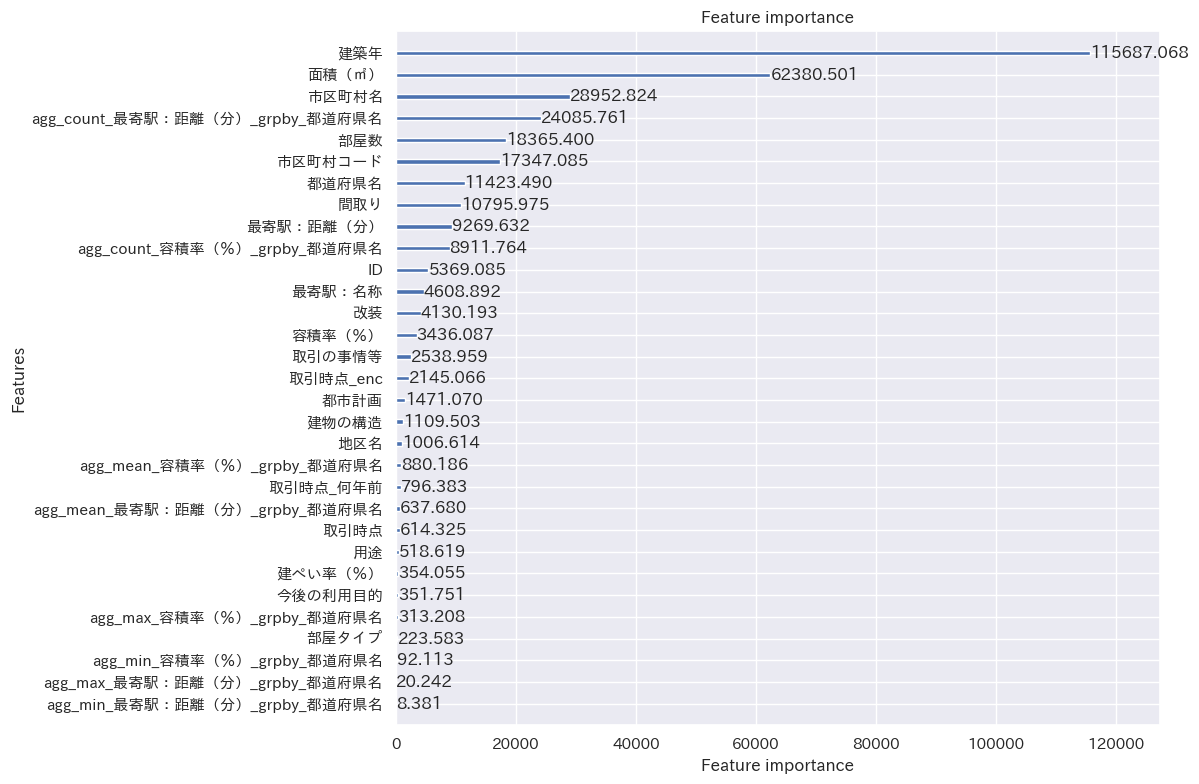

In [156]:
lgb.plot_importance(model, figsize=(12,8), max_num_features=50, importance_type='gain')
plt.tight_layout()
plt.savefig(BASE_PATH + 'output/feature_importance.png')
plt.show()
plt.close()

In [157]:
test_df[TARGET] = test_pred

/var/folders/sq/rqkt9m8947d5f6h6fxf4t9q00000gn/T/ipykernel_45276/88504142.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[TARGET] = test_pred


In [158]:
sub_df = pd.merge(sub_df[['ID']], test_df[['ID', TARGET]], on='ID')
sub_df.to_csv(BASE_PATH + 'output/test_submission.csv', index=False)